# Data Analysis - Velib project

We consider the [velib](https://www.velib-metropole.fr/donnees-open-data-gbfs-du-service-velib-metropole) data set, related to the bike sharing system of Paris. The data are loading profiles of the bike stations over one week, collected every hour, from the period Monday 2nd Sept. - Sunday 7th Sept., 2014. The loading profile of a station, or simply loading, is defined as the ratio of number of available bikes divided by the number of bike docks. A loading of 1 means that the station is fully loaded, i.e. all bikes are available. A loading of 0 means that the station is empty, all bikes have been rent.

From the viewpoint of data analysis, the individuals are the stations. The variables are the 168 time steps (hours in the week). **The aim is to detect clusters in the data, corresponding to common customer usages.** This clustering should then be used to predict the loading profile.

# <FONT COLOR="Red">Loading the data   </font>

In [3]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [4]:
path = 'velib_data/'
load = pd.read_csv(path + 'velibLoading.csv', sep = " ")
coord = pd.read_csv(path + 'velibCoord.csv', sep = " ")
print(load.shape)


(1189, 168)


In [5]:
print(coord.shape)
coord.head()

(1189, 4)


longitude   latitude  bonus              names
1   2.377389  48.886300      0   EURYALE DEHAYNIN
2   2.317591  48.890020      0          LEMERCIER
3   2.330447  48.850297      0    MEZIERES RENNES
4   2.271396  48.833734      0             FARMAN
5   2.366897  48.845887      0   QUAI DE LA RAPEE

This dataset is composed of two dataframes : The first one represents the loading of all the 1189 stations every hour over the week. The second on contains the coordinates (longitude, latitude), information about the altitude (bonus) and the names of all 1189 stations.

# <FONT COLOR="Red">Data verification   </font>

First off, we check if there is missing data or duplicate data

In [6]:
load.shape
#Data missing verification
load_miss = load.isna().any(axis=0).sum()
print(load_miss)
coord_miss = coord.isna().any(axis=0).sum()
print(coord_miss)

0
0


In [7]:
#Data duplicates verification
load_dupl = load.duplicated().sum()
print(load_dupl)
coord_dupl = coord.duplicated().sum()
print(coord_dupl)

0
0


The data appears to be completely clear from duplicate and missing values. We then check if any of the stations is present more than once in the data set.

In [8]:
# Stations in descending order of occurrence
station_names = coord.names.value_counts().sort_values(ascending=False)
print(f'number of stations present more than once : {np.sum([station_names>1])}')
print(station_names)

# --- #
print('')

# We display the station with the most occurrences, i.e. the station corresponding to the first line of 'station_name'.
name = station_names.index[0]
coord[coord.names == name]

number of stations present more than once : 26
names
 PORTE DES LILAS           3
 GARE D'AUSTERLITZ         3
 GARE DE L'EST             2
 AQUEDUC                   2
 DODU                      2
                          ..
 CHARONNE                  1
 BOUSSINGAULT - TOLBIAC    1
 RIVOLI MAIRIE DU 1ER      1
 JOURDAN BARBOUX           1
 QUAI VOLTAIRE             1
Name: count, Length: 1161, dtype: int64



longitude   latitude  bonus             names
362   2.404770  48.876604      1   PORTE DES LILAS
450   2.405960  48.875412      1   PORTE DES LILAS
957   2.411046  48.878099      1   PORTE DES LILAS

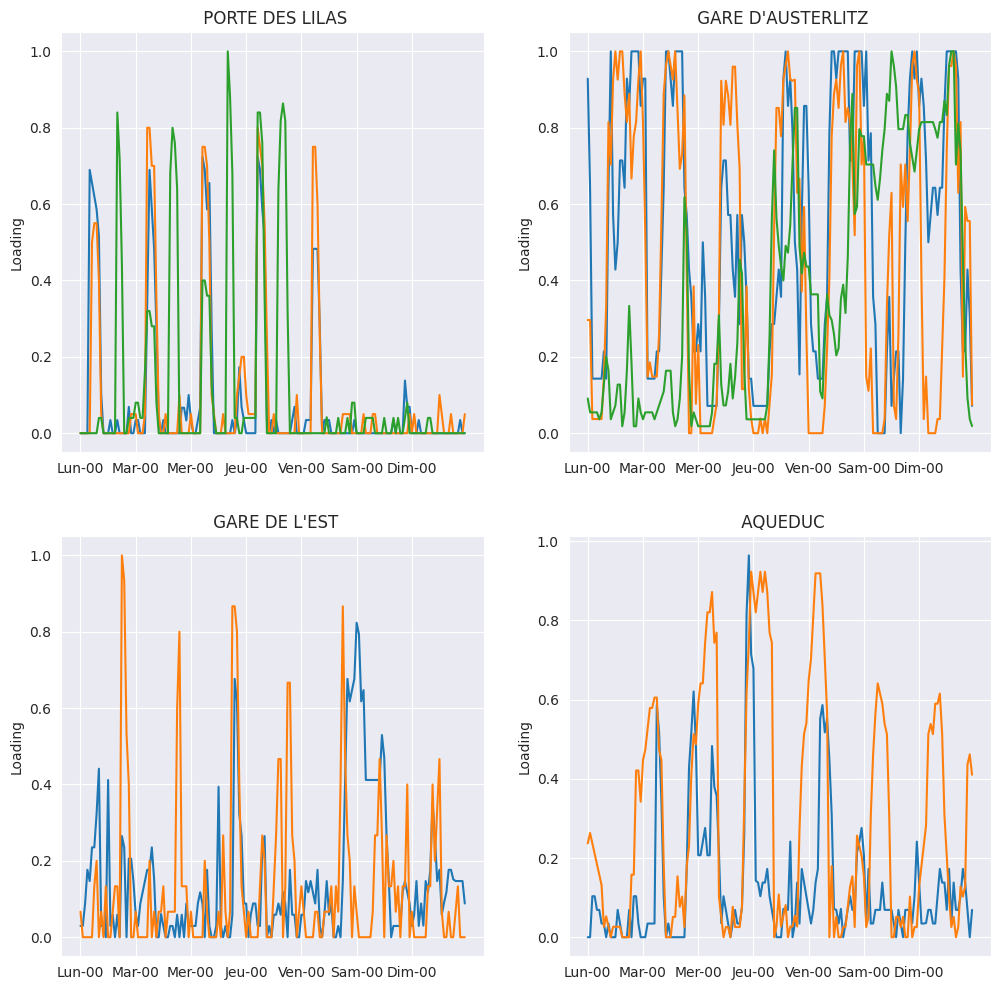

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

for k in range(4):
    row = k // 2
    col = k % 2

    for i in range(len(load[coord.names == station_names.index[k]])):
        ax[row, col].plot(load[coord.names == station_names.index[k]].iloc[i])

    ax[row, col].set_xticks(np.arange(0, 168, 24))
    ax[row, col].set_ylabel('Loading')
    ax[row, col].set_title(station_names.index[k])

plt.show()

We clearly see that the Loading profiles corresponding to different instances of the same stations are everytime completely different.

# <FONT COLOR="Red">Data visualization   </font>

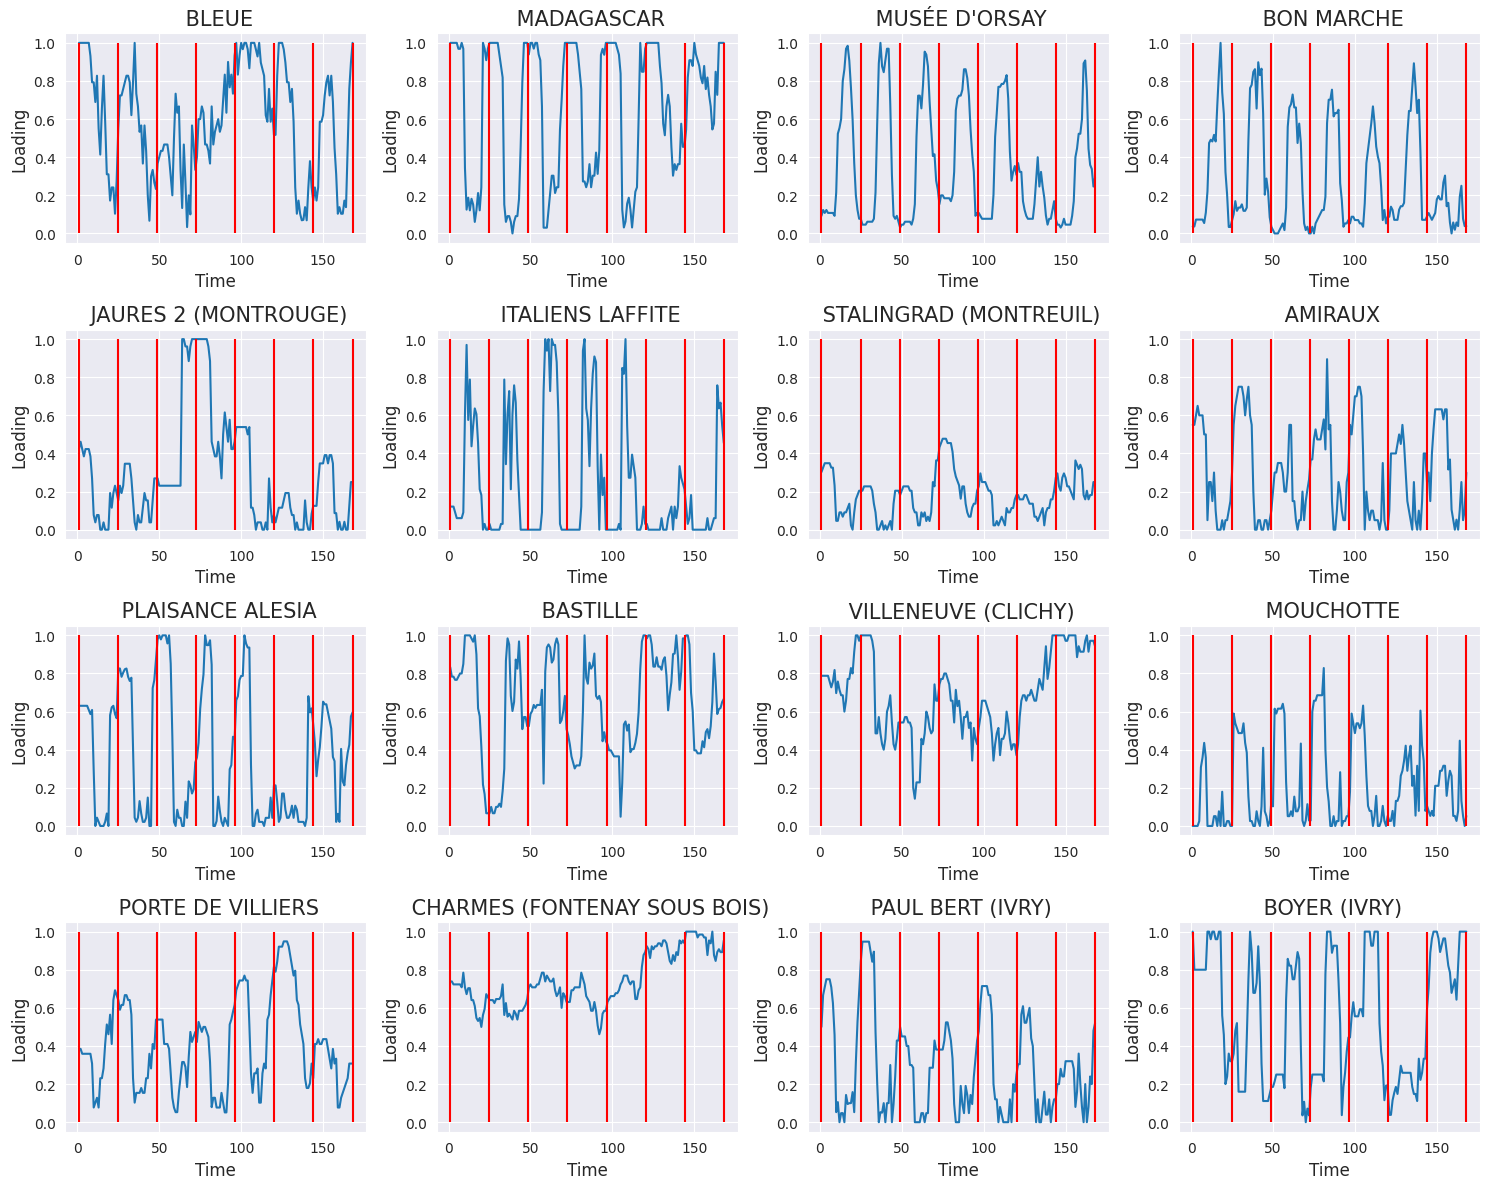

In [10]:
#Does loading differ between station
loading_data = load.to_numpy()

n_steps = loading_data.shape[1]  # number of observed time steps
time    = np.linspace(1,n_steps,n_steps)  # observed time range
days = np.linspace(1,n_steps,8)

stations = rd.sample(range(0,loading_data.shape[0]),16)
fig, axes = plt.subplots(4,4,figsize=(15, 12))

for j in range(16) :
    row = j // 4  # Calculate the row index
    col = j % 4   # Calculate the column index

    axes[row, col].plot(time, loading_data[stations[j]])
    axes[row, col].vlines(days, 0, 1, color='r')

    axes[row, col].set_xlabel('Time', fontsize=12)
    axes[row, col].set_ylabel('Loading', fontsize=12)
    axes[row, col].set_title(coord.names[stations[j]+1], fontsize=15)

plt.tight_layout()
plt.show()

Loading profiles of station differs a lot from one to another.
We have to look some clusters in the data in order to detect similarities behavior between stations

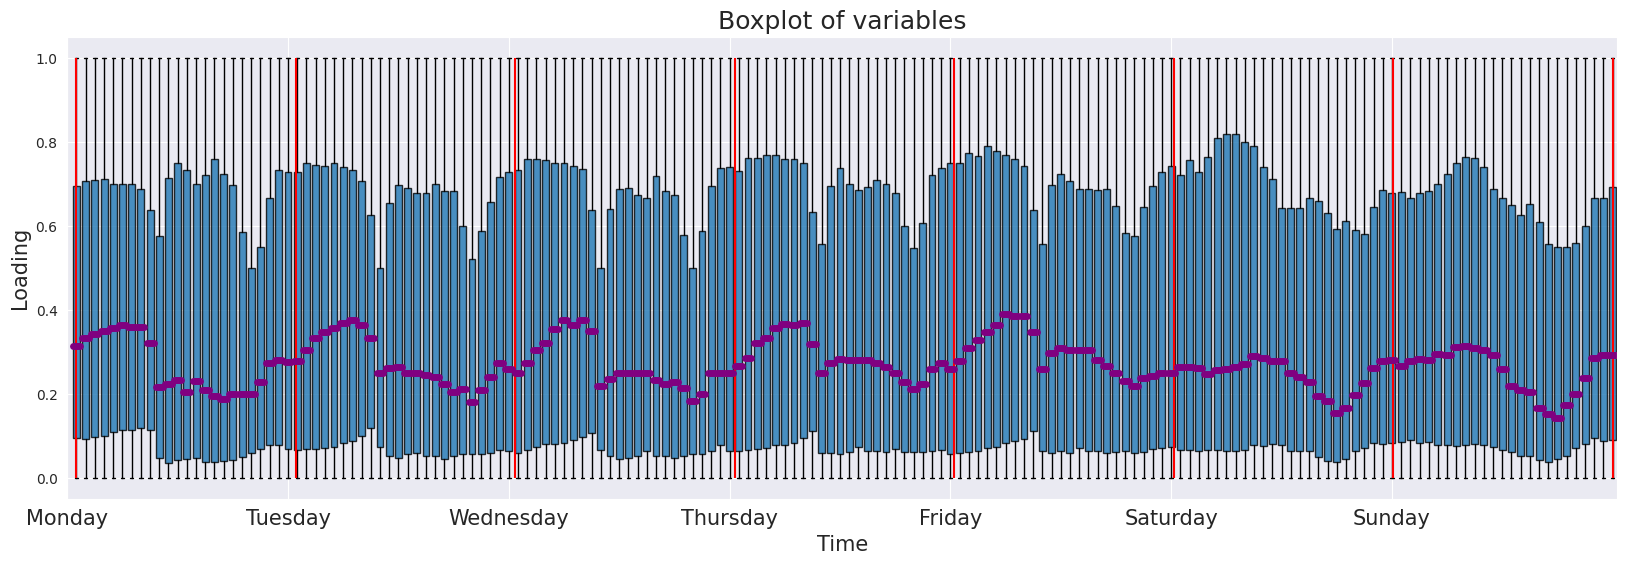

In [11]:
#Boxplot of the variable to see distribution
#The boxplot of the 168 variables (each hour of the week) are concentred and can be see as a graph
plt.figure(figsize=(20, 6))
bp = plt.boxplot(loading_data, widths = 0.75, patch_artist = True)
plt.vlines(days,0,1,color ='r')
week = ["Monday", "Tuesday", "Wednesday","Thursday", "Friday", "Saturday", "Sunday"]

for box in bp['boxes']:
    box.set_alpha(0.8)
for median in bp['medians']:
    median.set(color = "Purple", linewidth=5)

plt.xlabel('Time', fontsize=15)
plt.ylabel('Loading', fontsize=15)
plt.title('Boxplot of variables', fontsize=18)
plt.xticks(ticks = np.arange(0, 168, 5), labels=np.arange(0, 168, 5), fontsize = 15)
plt.xticks(ticks=np.arange(0, 168, 24), labels=week, fontsize=15)
plt.show()

We can see the mean process follows one same behavior on work days and a different one on the week-end.

In [12]:
#Average fill rate
print('--- Average fill rate ---')
mean = loading_data.mean()
average_loading = np.mean(loading_data, axis = 1)
print(mean)

# --- #
print('')

print('--- Least crowded station, on average ---')
min_mean = np.min(average_loading)
argmin_mean = np.argmin(average_loading)
print("Mean min : ", min_mean)
print("Least crowded station : ",argmin_mean + 1," :",coord.names[argmin_mean + 1])

# --- #
print('')

print('--- Fullest station, on average ---')
max_mean = np.max(average_loading)
argmax_mean = np.argmax(average_loading)
print("Mean max : ", max_mean)
print("Fullest station : ",argmax_mean + 1," :",coord.names[argmax_mean + 1])

--- Average fill rate ---
0.3816217759807477

--- Least crowded station, on average ---
Mean min :  0.016132842025699153
Least crowded station :  997  :  HORNET (BAGNOLET)

--- Fullest station, on average ---
Mean max :  0.9193722943722953
Fullest station :  1107  :  INSURRECTION AOUT 1944 (IVRY)


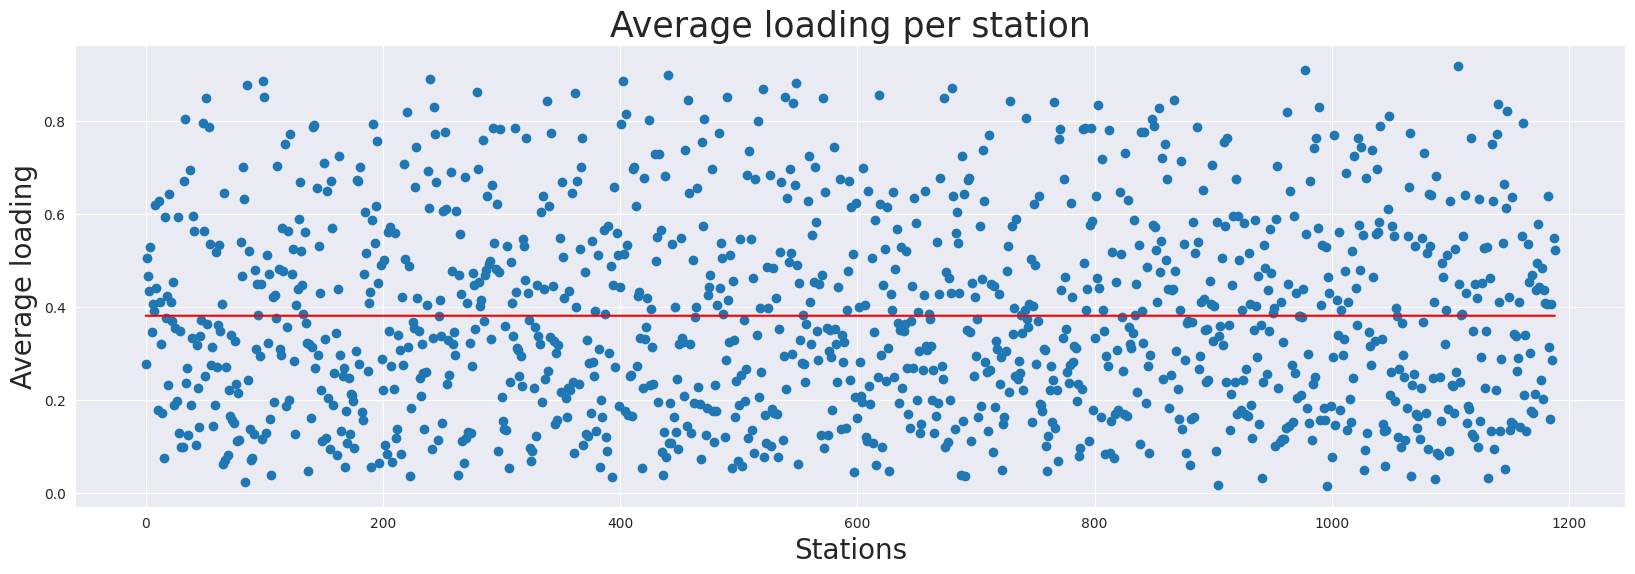

In [13]:
#Variability of the average fill rate between station

plt.figure(figsize=(20,6))
plt.plot(average_loading,marker='o',linestyle='None')
plt.plot(np.ones_like(average_loading)*mean,color = 'red')
plt.xlabel('Stations', fontsize = 20)
plt.ylabel('Average loading', fontsize = 20)
plt.title("Average loading per station", fontsize = 25)
plt.show()

average fill rate differs a lot between the stations,
we can't discern any patterns on this graph.

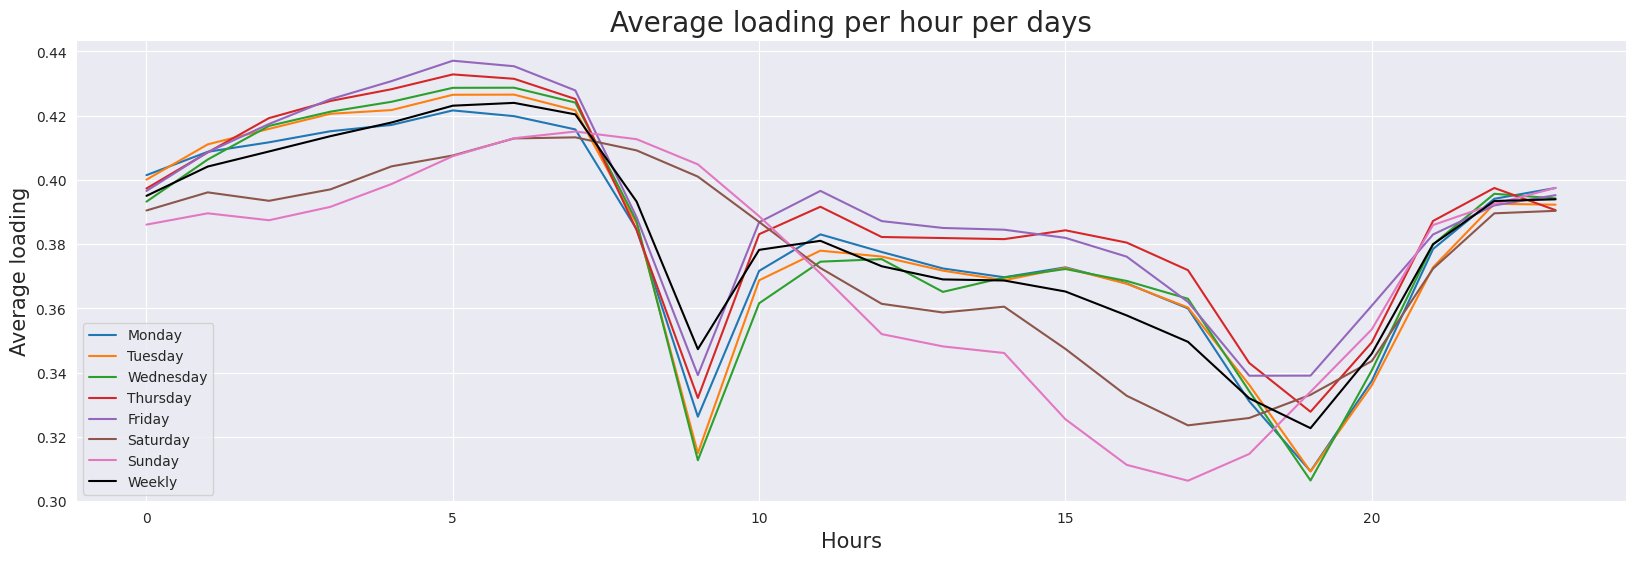

In [14]:
#average fil rate between days
mean_per_hour_per_day = loading_data.mean(axis=0).reshape((7,24))
mean_per_hour = mean_per_hour_per_day.mean(axis=0)

plt.figure(figsize=(20,6))
plt.plot(mean_per_hour_per_day.transpose())
plt.plot(mean_per_hour, color = 'black')
plt.xlabel('Hours', fontsize = 15)
plt.ylabel('Average loading', fontsize = 15)
plt.legend(week + ['Weekly'])
plt.title("Average loading per hour per days", fontsize = 20)
plt.show()

We clearly see that le average fill rate showcases different behaviour depending on whether it is a week day or week end day

## Influence of the time of the day

In [15]:
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import plotly.express as px

In [16]:
night_hours = {"00", "01", "02", "03", "04", "05", "06", "21", "22", "23"}
a=np.mean([load[col] for col in load.columns if any(col.endswith(hour) for hour in night_hours)])
b=np.mean([load[col] for col in load.columns if not (any(col.endswith(hour) for hour in night_hours))])
print(f'average loading during the night :{a} \n average loading during the day {b}')


average loading during the night :0.40541576859359046 
 average loading during the day 0.3646260669715743


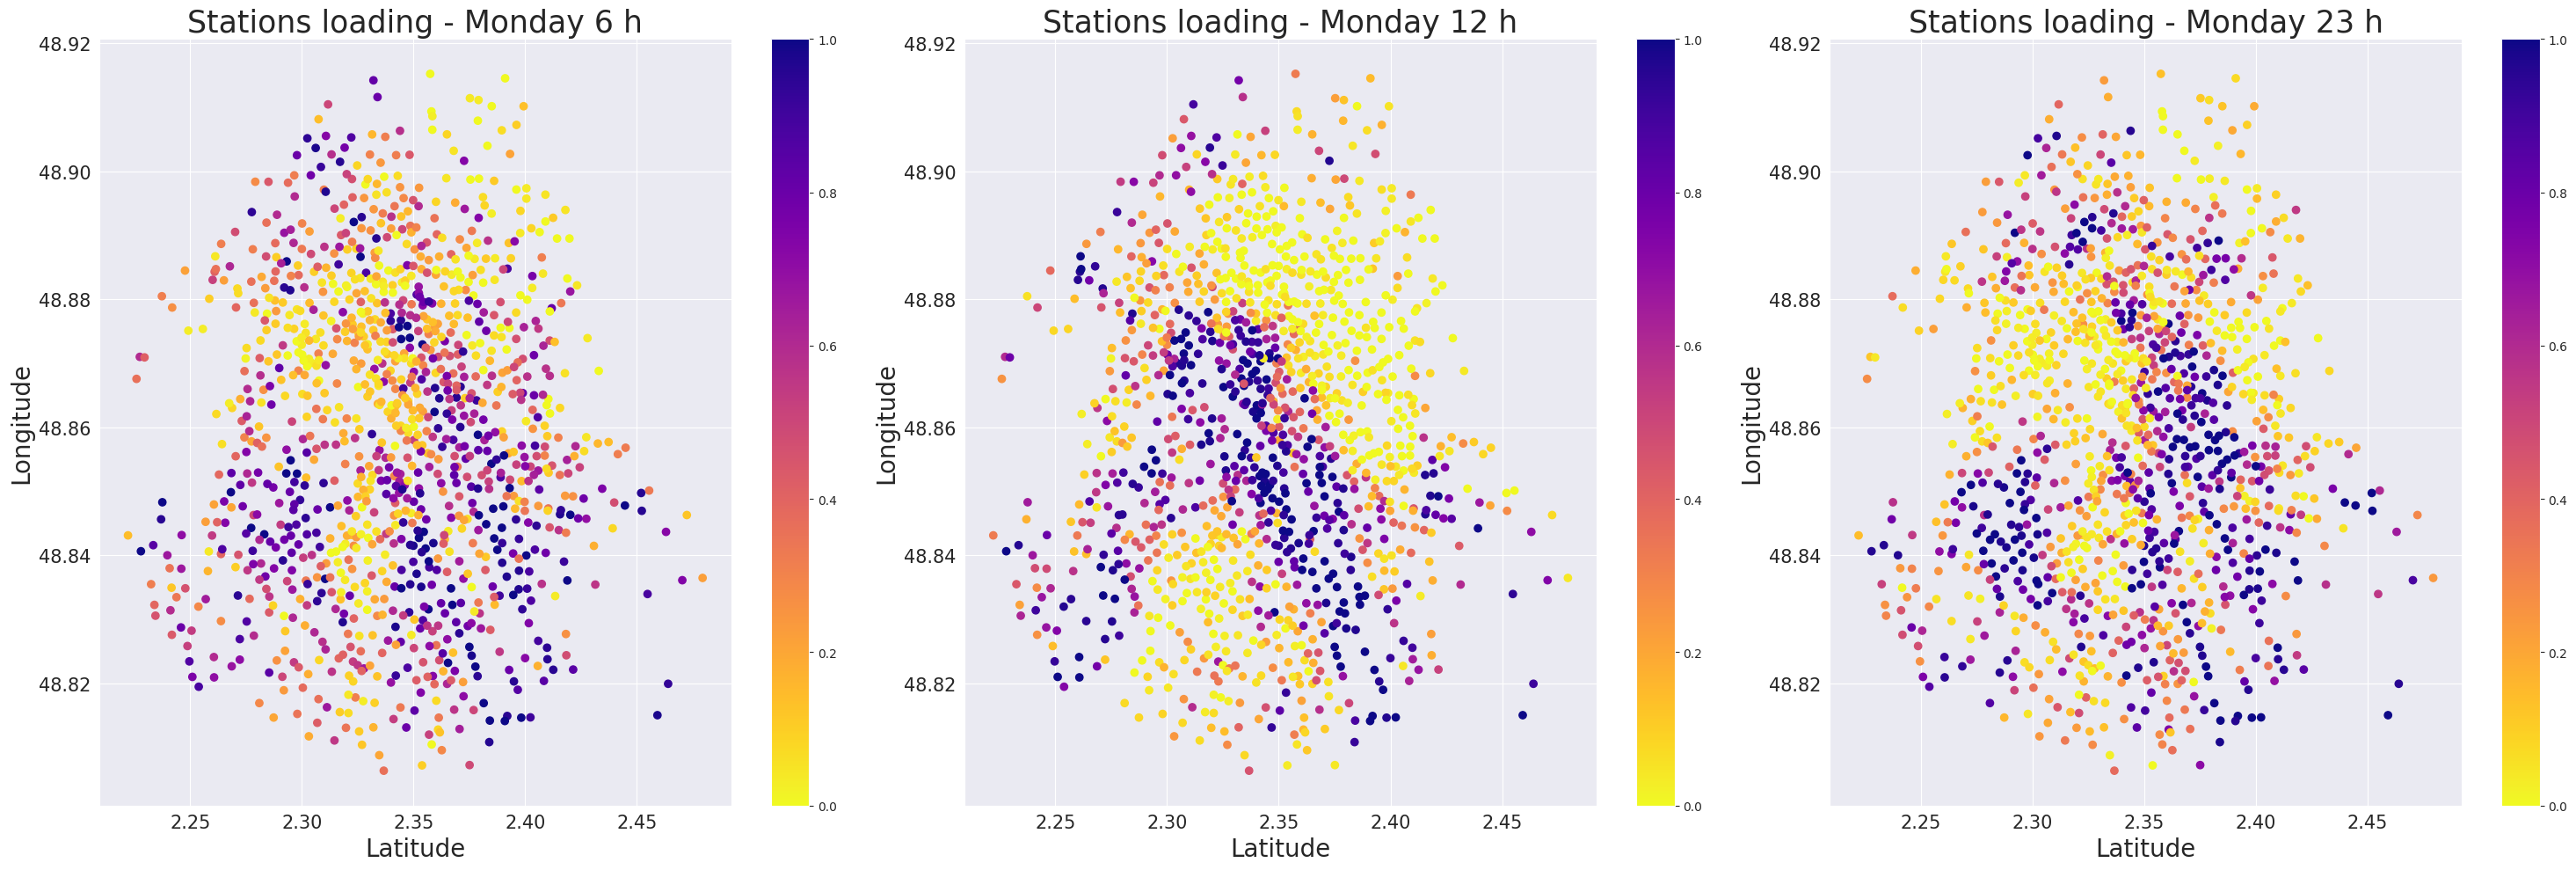

In [17]:
hours = [6, 12, 23]

# --- #

s, n = 10, len(hours)
fig, axs = plt.subplots(1, n, figsize = (s*n, s))

for (i,h) in enumerate(hours):
    im = axs[i].scatter(coord.longitude, coord.latitude, c = loading_data[:,h], cmap = cm.plasma_r)
    axs[i].set_title('Stations loading - Monday {} h'.format(h), fontsize = 25)
    plt.colorbar(im, ax=axs[i])

for ax in axs.flat:
    ax.set_xlabel('Latitude', fontsize = 20)
    ax.set_ylabel('Longitude', fontsize = 20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

plt.tight_layout()
plt.show()

We seem to observe some cycling pattern : the average loading profile of the city changes from the morning during the day until it goes back to its original profile during the night.

interactive(children=(IntSlider(value=0, description='Hour :', layout=Layout(height='30px', width='50%'), max=…

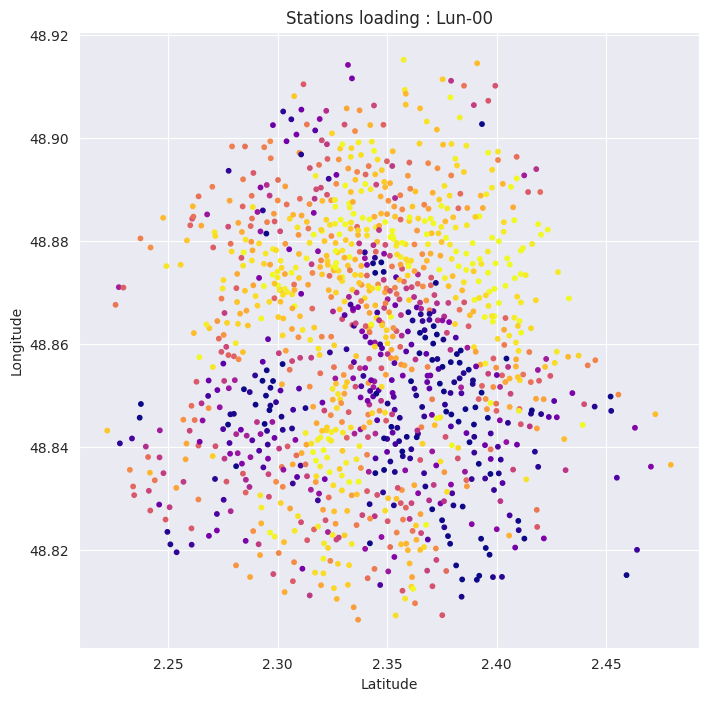

In [18]:
from ipywidgets import interactive, IntSlider, Layout

def plot_graph(hour,day):
    plt.figure(figsize=(8,8))
    plt.scatter(coord.longitude, coord.latitude, c = loading_data[:,day*24+hour], cmap = cm.plasma_r,s=10)
    plt.colorbar(im)
    plt.title('Stations loading : '+load.columns[day*24+hour])
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')

hour_slider = IntSlider(min=0, max=23, step=1, value=0, description='Hour :',layout=Layout(width='50%', height='30px'))
day_slider = IntSlider(min=0, max=6, step=1, value=0, description='Day :',layout=Layout(width='50%', height='30px'))
interactive_plot = interactive(plot_graph, hour=hour_slider,day=day_slider)
interactive_plot

During work days, we see a sudden change from 8 to 9 am where the furthest stations from the city center get emptied for the city center ones to be filled corresponding to the morning rush. In the evening the opposite movement takes place more smoothly from 5pm to 8pm : Clearly these movement are the consequences of people going to work in the city center. Such thing should also happen around universities.

During the week end days, we observe a similar gathering movement happening between 11pm and 3pm : people go in the city center for leisure purposes. From 7pm and all throughout the night, the opposite movement takes place : people take the bikes in the city center to go back home.

Over all, stations in the center get loaded during daytime. There is a gathering bouncing movement that takes place during specific gathering hours.

## Influence of altitude

Map of Hilltop stations

In [19]:
coord['hill'] = coord['bonus'].astype('category') # convert to categorical

# --- #

fig = px.scatter_mapbox(coord, lat = 'latitude', lon = 'longitude',
                        mapbox_style = "carto-positron",
                        color = 'hill',
                        color_discrete_map = {0:'midnightblue', 1:'plum'},
                        labels = {0: "hello", 1: "hi"},
                        zoom = 10, opacity = .9,
                        title = 'Hilltop stations')

fig.update_layout(
    height=800,
    width=1000,
)
fig.show()

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1971: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(required_grouper, sort=False)  # skip one_group groupers


Comparison between valley and hill stations

In [20]:
#Splitting the dataset
loading_hill  = loading_data[coord.bonus == 1]
loading_valley = loading_data[coord.bonus == 0]

In [21]:
#Average fill rate

print('--- Average fill rates ---')
mean_hill = loading_hill.mean()
mean_valley = loading_valley.mean()

print(f'mean for hilltop stations : {mean_hill} / mean for valley stations {mean_valley}')

--- Average fill rates ---
mean for hilltop stations : 0.16104660259524076 / mean for valley stations 0.40799940970952314


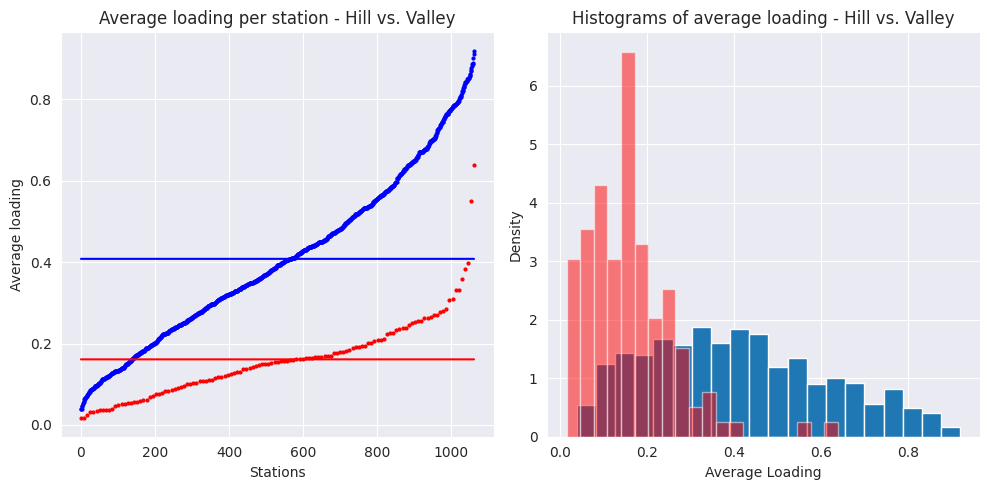

In [22]:
meanR_hill = np.mean(loading_hill, axis = 1)
meanR_valley = np.mean(loading_valley, axis = 1)
meanR_hill_sorted = np.sort(meanR_hill)
meanR_valley_sorted = np.sort(meanR_valley)

fig, ax =plt.subplots(1,2,figsize=(10,5))
ax[0].plot(meanR_valley_sorted,marker='o',linestyle='None',color='blue',markersize=2)
ax[0].plot(np.ones_like(meanR_valley)*mean_valley,color = 'blue')
ax[0].plot(np.linspace(0, len(meanR_valley), len(meanR_hill)),meanR_hill_sorted,marker='o',linestyle='None',color='red',markersize=2)
ax[0].plot(np.ones_like(meanR_valley)*mean_hill,color = 'red')
ax[0].set_xlabel('Stations')
ax[0].set_ylabel('Average loading')
ax[0].set_title("Average loading per station - Hill vs. Valley")

ax[1].hist(meanR_valley,bins=20,density=True)
ax[1].hist(meanR_hill,bins=20,color='red',density=True,alpha=0.5)
ax[1].set_title('Histograms of average loading - Hill vs. Valley')
ax[1].set_xlabel('Average Loading')
ax[1].set_ylabel('Density')
plt.tight_layout()
plt.show()

Most of the hill stations are way less crowded, still we observe two hill stations that seem to have a significantly higher loading

Remark : Sorting the values to plot the graph on the left doesn't lose any information since the numbering order of the stations doesn't represent anything. We will prefer this representation rather than just a normal scatter for more visibility.

In [23]:
#Print the most loaded hill stations
hill_coord= coord[coord.bonus == 1]
hill_load=load[coord.bonus == 1]
h= pd.Series(hill_load.mean(axis=1))

sorted_indexes = []

for s in range(9):
    i = h.idxmax()
    sorted_indexes.append(i)
    if s<3:
        print('Average fill rate:', h[i])
        print(coord.loc[i])
    h.drop(index=i, inplace=True)

sorted_hill_coords=coord.loc[sorted_indexes]
sorted_hill_load=pd.Series(hill_load.mean(axis=1)).loc[sorted_indexes]

Average fill rate: 0.6375793650793655
longitude              2.33671
latitude              48.80638
bonus                        1
names         DOUMER (ARCUEIL)
hill                         1
Name: 1153, dtype: object
Average fill rate: 0.5491434821791962
longitude               2.280989
latitude                48.81694
bonus                          1
names         LARMEROUX (VANVES)
hill                           1
Name: 1077, dtype: object
Average fill rate: 0.3965728715728717
longitude            2.3215
latitude            48.8337
bonus                     1
names         DIDOT CHATEAU
hill                      1
Name: 427, dtype: object


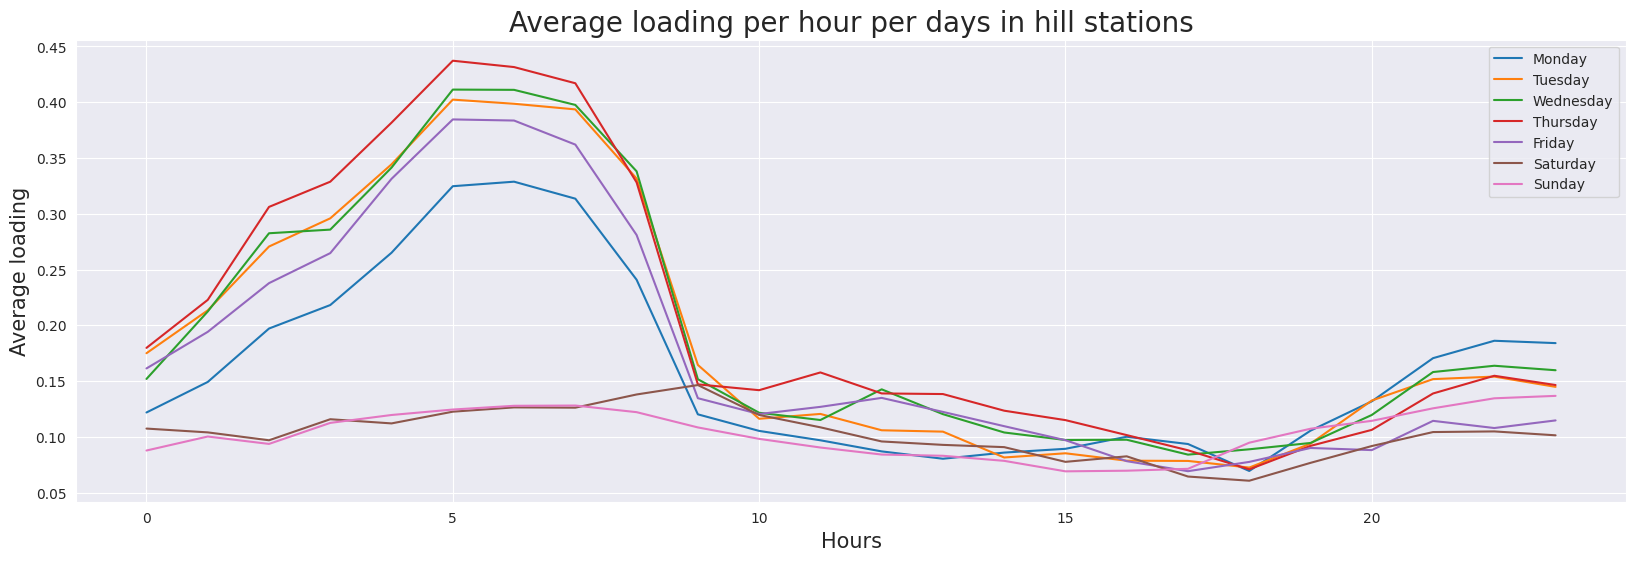

In [24]:
hill_mean_per_hour_per_day = loading_hill.mean(axis=0).reshape((7,24))
valley_mean_per_hour_per_day = loading_valley.mean(axis=0).reshape((7,24))


plt.figure(figsize=(20,6))
plt.plot(hill_mean_per_hour_per_day.transpose())
plt.xlabel('Hours', fontsize = 15)
plt.ylabel('Average loading', fontsize = 15)
plt.legend(week + ['Weekly'])
plt.title("Average loading per hour per days in hill stations", fontsize = 20)
plt.show()

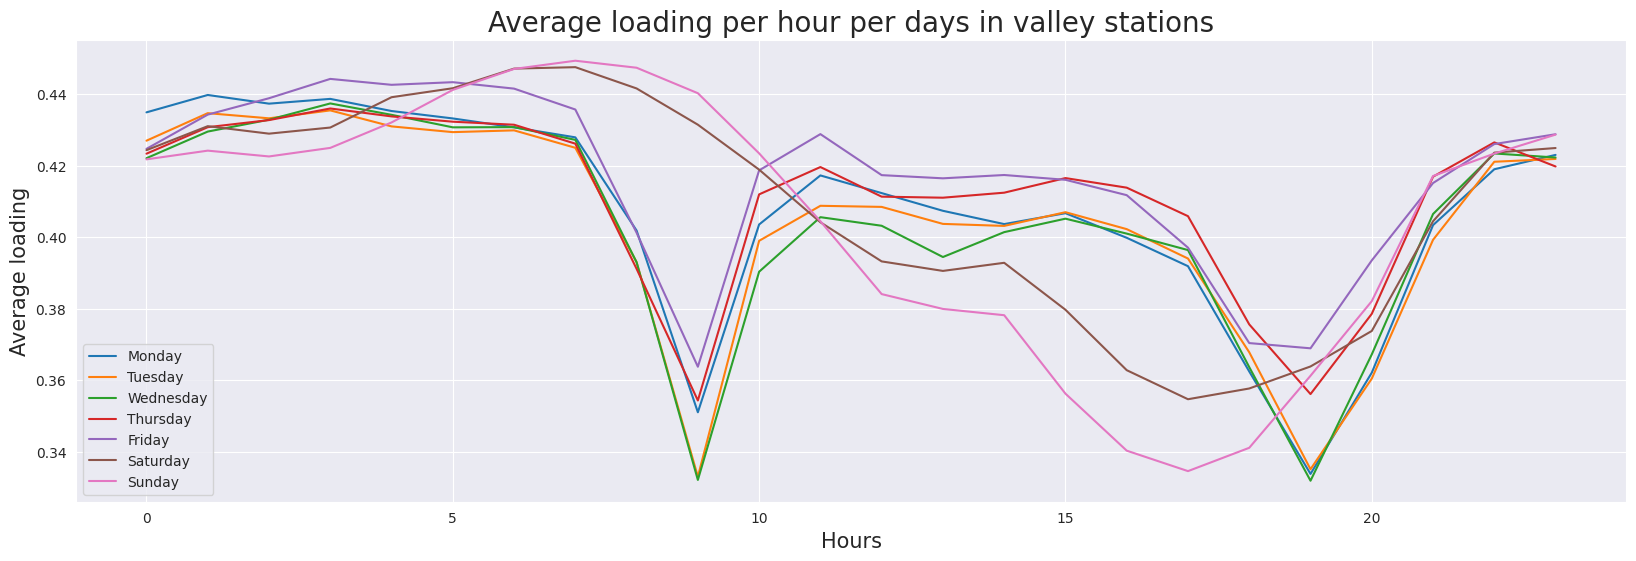

In [25]:
plt.figure(figsize=(20,6))
plt.plot(valley_mean_per_hour_per_day.transpose())
plt.xlabel('Hours', fontsize = 15)
plt.ylabel('Average loading', fontsize = 15)
plt.legend(week + ['Weekly'])
plt.title("Average loading per hour per days in valley stations", fontsize = 20)
plt.show()

In [26]:
blues_custom = [(0.0, '#b9d6f2'), (0.2, '#7da8e4'), (0.4, '#457dd5'), (0.6, '#1351c8'), (0.8, '#0025bb'), (1.0, '#08306b')]
fig = px.scatter_mapbox(sorted_hill_coords, lat='latitude', lon='longitude',
                        color=sorted_hill_load,  # Set colors based on load values
                        mapbox_style="carto-positron",
                        zoom=10,
                        title='Most loaded hill stations',
                        color_continuous_scale=blues_custom)
fig.update_layout(
    height=800,
    width=1000,
)
fig.show()

They seem to be concentrated over the south hills, which whether arent high hills or just that there tends to be more loading in the south

## Influence of localisation

In [27]:
hours15=np.arange(15,168,24)
hours4=np.arange(4,168,24)
average_loading15=loading_data[:,hours15].mean(axis=1)
average_loading4=loading_data[:,hours4].mean(axis=1)

fig = px.scatter_mapbox(coord, lat = 'latitude', lon = 'longitude',
                        mapbox_style = "carto-positron",
                        color = average_loading15, color_continuous_scale = px.colors.sequential.Plasma_r, #size = load_per_hour,
                        zoom  = 10, opacity = .9,
                        title = 'Stations loading - average loading at 3pm')
fig.update_layout(
    height=800,
    width=1000,
)

fig.show()

For the loading average around 3pm, we notice a clear tendency : stations along the Seine river seem to be more loaded.

In [28]:
Seine=pd.read_csv(path+'Seine.csv',sep=' ')
Seine.head()

longitude   latitude
0   2.223521  48.841269
1   2.222816  48.837307
2   2.224930  48.834080
3   2.226459  48.830257
4   2.229531  48.826785

In [29]:
fig = px.scatter_mapbox(Seine, lat='latitude', lon='longitude',
                        mapbox_style="carto-positron",
                        zoom=10,
                        title='The Seine')
fig.update_layout(
    height=800,
    width=1000,
)
fig.show()

In [30]:
max_distances=[]
numpy_Seine=Seine.to_numpy()
for index, row in coord.iterrows():
    max_distances.append(min([np.linalg.norm(point - [row['longitude'],row['latitude']]) for point in numpy_Seine]))

blues_custom = [(0.0, '#b9d6f2'), (0.2, '#7da8e4'), (0.4, '#457dd5'), (0.6, '#1351c8'), (0.8, '#0025bb'), (1.0, '#08306b')]
fig = px.scatter_mapbox(coord, lat='latitude', lon='longitude',
                        color=max_distances,  # Set colors based on max distances from the Seine
                        mapbox_style="carto-positron",
                        zoom=10,
                        title='Stations closest to the Seine',
                        color_continuous_scale=blues_custom)
fig.update_layout(
    height=800,
    width=1000,
)
fig.show()

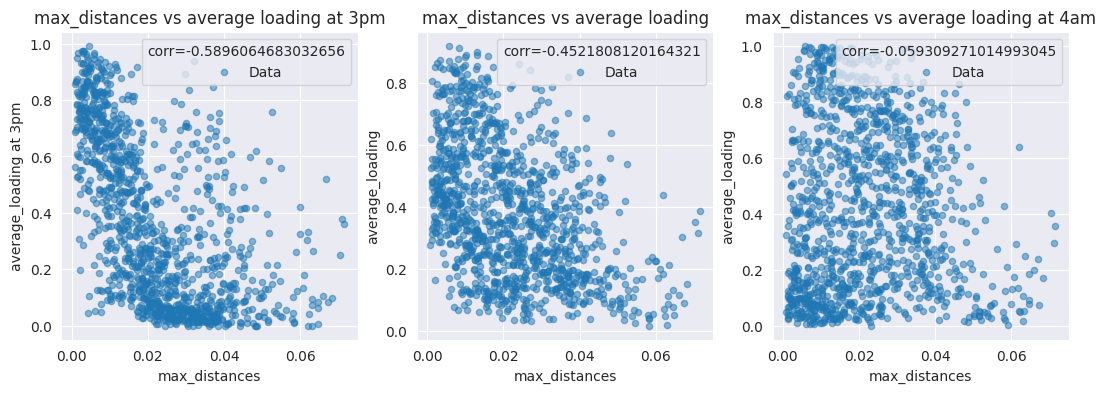

In [31]:
max_distances=np.array(max_distances)

fig, ax =plt.subplots(1,3,figsize=(13,4))

scatter1 = ax[0].scatter(max_distances, average_loading15, alpha=0.5, s=20, label='Data')
ax[0].set_title('max_distances vs average loading at 3pm')
ax[0].set_xlabel('max_distances')
ax[0].set_ylabel('average_loading at 3pm')
ax[0].legend(title=f'corr={np.corrcoef(max_distances,average_loading15)[0, 1]}')

scatter2 = ax[1].scatter(max_distances, average_loading, alpha=0.5, s=20, label='Data')
ax[1].set_title('max_distances vs average loading')
ax[1].set_xlabel('max_distances')
ax[1].set_ylabel('average_loading')
ax[1].legend(title=f'corr={np.corrcoef(max_distances,average_loading)[0, 1]}')

scatter3 = ax[2].scatter(max_distances, average_loading4, alpha=0.5, s=20, label='Data')
ax[2].set_title('max_distances vs average loading at 4am')
ax[2].set_xlabel('max_distances')
ax[2].set_ylabel('average_loading')
ax[2].legend(title=f'corr={np.corrcoef(max_distances,average_loading4)[0, 1]}')

plt.show()

For graphs 1 and 2, even though the correlation is not too high, there clearly is a linear relation between the average loading and the distance from the Seine :
The further we go from the Seine are the lower is the loading average. This relation is particularly true if we look at the average around 3pm when people are supposed to be gathered in the city center.

However, we cannot assume there really is a linear relation for the average loading at 4am. We then run some pearson correlation tests to assert our assumptions.

In [32]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(average_loading15, max_distances)
print("Valeur p du test de nullité de la pente (average_loading15,max_distances):", p_value)

slope, intercept, r_value, p_value, std_err = stats.linregress(average_loading, max_distances)
print("Valeur p du test de nullité de la pente (average_loading,max_distances):", p_value)


slope, intercept, r_value, p_value, std_err = stats.linregress(average_loading4, max_distances)
print("Valeur p du test de nullité de la pente (average_loading4,max_distances):", p_value)

Valeur p du test de nullité de la pente (average_loading15,max_distances): 3.1136476775434206e-112
Valeur p du test de nullité de la pente (average_loading,max_distances): 5.6025422064536896e-61
Valeur p du test de nullité de la pente (average_loading4,max_distances): 0.04088008500402586


Here, we perform a simple linear regression between the variables then checking the nullity of the slope parameter with a student test : $\mathcal{H}_0$ : There is no linear relationship between the variables.

For the two first tests, we of course assume there is a linear relation though the correlation coefficient printed before was already hard evidence.

For the last one, it is less obvious since the p-value approx equals 0.04 still we decide there is sufficient evidence to conclude a linear relationship between the average loading at 4am and the distance from the Seine.

In the last cells, we took the distance from the Seine as the reference variable to represent the center of activities.

We might as well just test whether the variables Average loading at hour x are independent or not from longitude latitude variables or also radius and angle from the city center point.

To define the city center point we take the geometric center of the Paris surface, which gets located at the tip of the Île de la Cité, at the level of Place Dauphine.

In [33]:
radius=[]
center_point=np.array([48.8569262793918,2.3413513652516027])
for index, row in coord.iterrows():
    radius.append(np.linalg.norm(center_point - [row['latitude'],row['longitude']]))

fig = px.scatter_mapbox(coord, lat='latitude', lon='longitude',
                        color=radius,  # Set colors based on max distances from the city center
                        mapbox_style="carto-positron",
                        zoom=10,
                        title='Stations closest to the city center',
                        color_continuous_scale=blues_custom)
fig.add_trace(
    px.scatter_mapbox(
        lat=[center_point[0]],
        lon=[center_point[1]],
        size=[10],  # Set size of the center point
    ).data[0]
)
fig.update_layout(
    height=800,
    width=1000,
)
fig.show()

In [34]:
slope, intercept, r_value, p_value, std_err = stats.linregress(average_loading,radius)
print("Valeur p du test de nullité de la pente (average_loading,radius):", p_value)

Valeur p du test de nullité de la pente (average_loading,radius): 0.017385298275952598


Once again, we conclude to a correlation between the distance from the city center and the average loading

# <FONT COLOR="Red">Clustering on transposed data   </font>

By applying clustering algorithms to the transposed data, we want to complete and assert our previous interpretations made while observing the loading map over the different hours and the days.

We want to see if there is more than just the "day" map profile where bikes are gathered in the center and the "night" map profile where they are more spread in the city. Maybe there is also a difference between the "day" profile for week days, and "day" profile for week-end days.

# ACP on transposed data

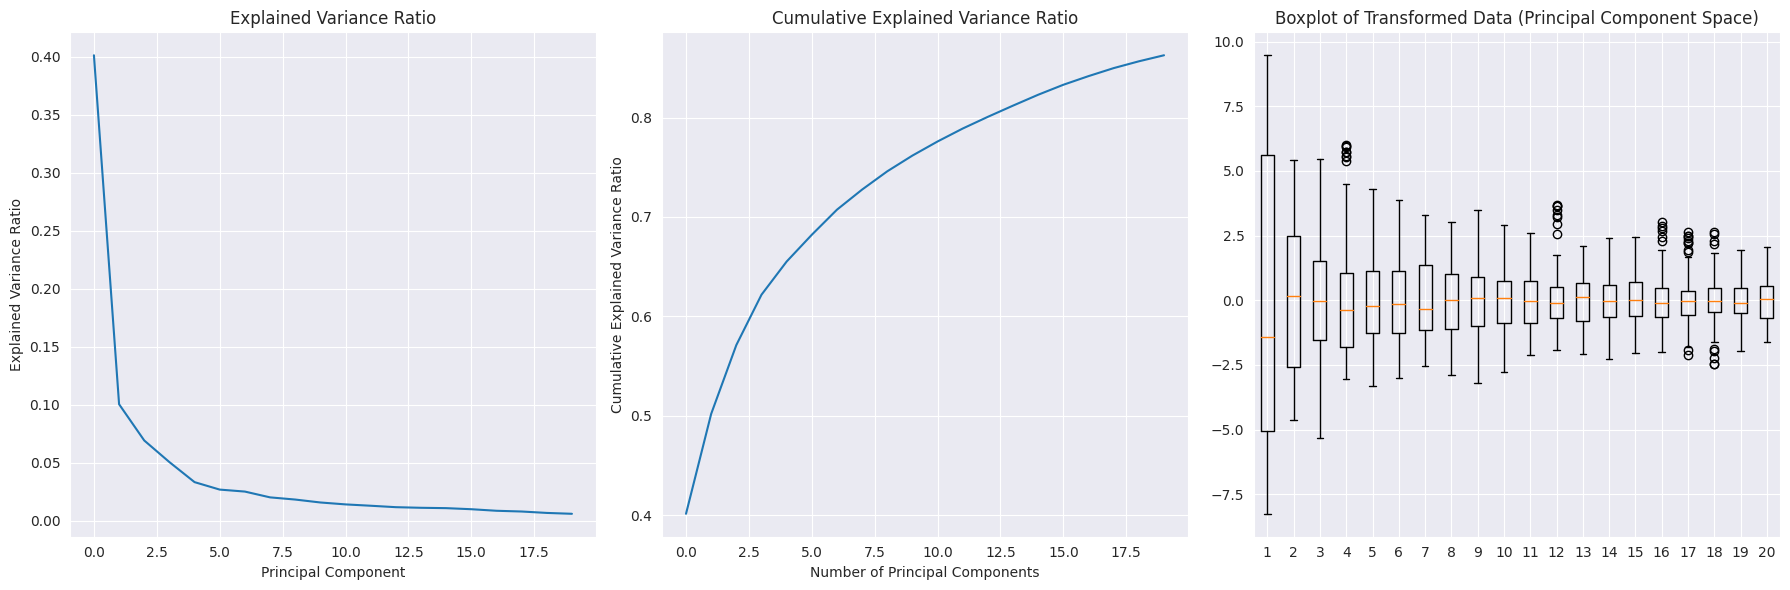

In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
loading_data_transpose=loading_data.T

pca.fit(loading_data_transpose)
data_pca = pca.transform(loading_data_transpose)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Explained variance ratio
axes[0].plot(pca.explained_variance_ratio_)
axes[0].set_title('Explained Variance Ratio')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')

# Cumulative explained variance ratio
axes[1].plot(np.cumsum(pca.explained_variance_ratio_))
axes[1].set_title('Cumulative Explained Variance Ratio')
axes[1].set_xlabel('Number of Principal Components')
axes[1].set_ylabel('Cumulative Explained Variance Ratio')

# Boxplot of the transformed data in the principal component space
axes[2].boxplot(data_pca)
axes[2].set_title('Boxplot of Transformed Data (Principal Component Space)')

plt.tight_layout()
plt.show()


The elbow method suggets we choose to keep only 2 components, although the cumulative explained variance only reaches 0.6 which could be better.

# Clustering on transposed data/transposed PCA data

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

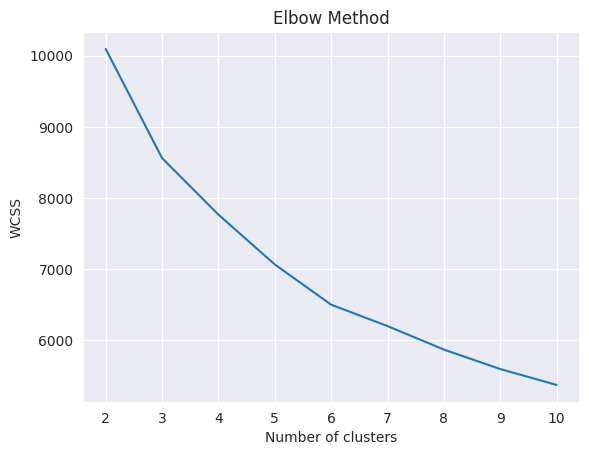

In [36]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

wcss = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(loading_data_transpose)
    wcss.append(kmeans.inertia_)  # inertia_ gives the WCSS value

plt.plot(range(2, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

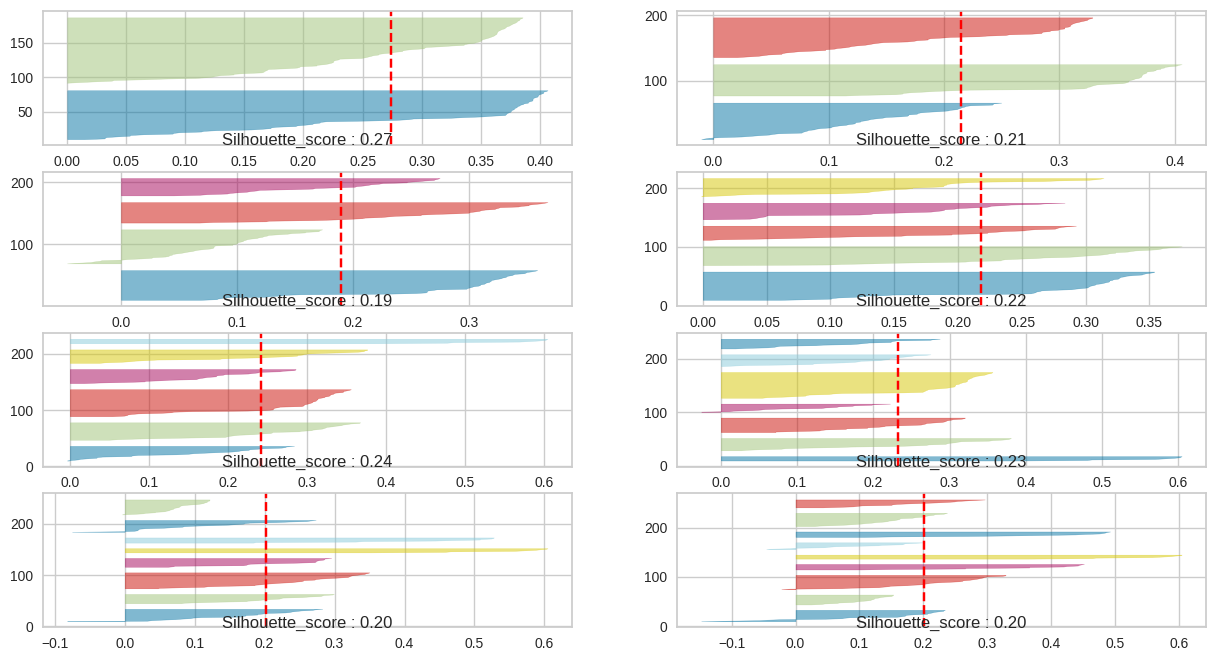

In [37]:
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(4,2, figsize=(15,8))

for k in range(2,10) :
    kmeans=KMeans(n_clusters=k,random_state=0)
    q,mod=divmod(k,2)
    visualizer=SilhouetteVisualizer(kmeans,colors='yellowbrick',ax=ax[q-1][mod])
    visualizer.fit(loading_data_transpose)
    silhouette_score=visualizer.silhouette_score_
    ax[q-1][mod].text(0.5,0,f'Silhouette_score : {silhouette_score:.2f}',transform=ax[q-1][mod].transAxes,ha='center')

plt.show()

These graphs suggest we consider 2 or 4 clusters to perform K means on our original data : for two clusters, the WCSS is relatively high but adding more clusters doesn't decrease sharply the error. The choice of 4 clusters also makes sence because silhouette score is locally maximized, also the decreasing in WCSS between 3 and 5 clusters really isn't significant. 8 Cluster could have been a pretty good choice since Silhouette score peaks at 8, meaning we have better separated and explained clusters, but for the sake of simplicity of limit ourselves to 4 clusters.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

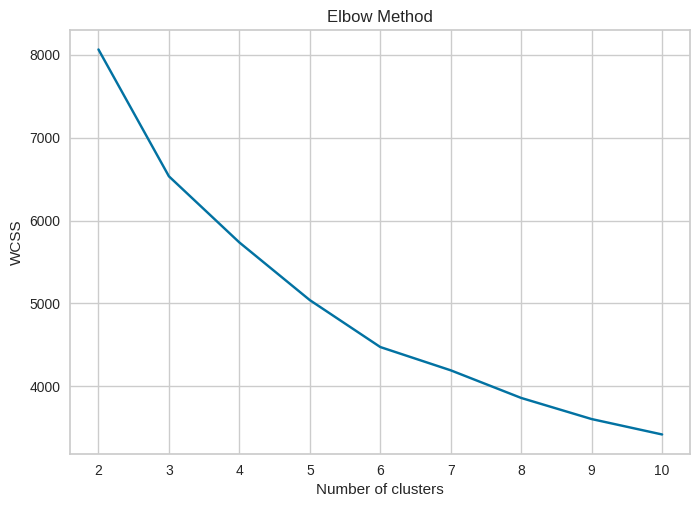

In [38]:
wcss = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(data_pca)
    wcss.append(kmeans.inertia_)  # inertia_ gives the WCSS value

plt.plot(range(2, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

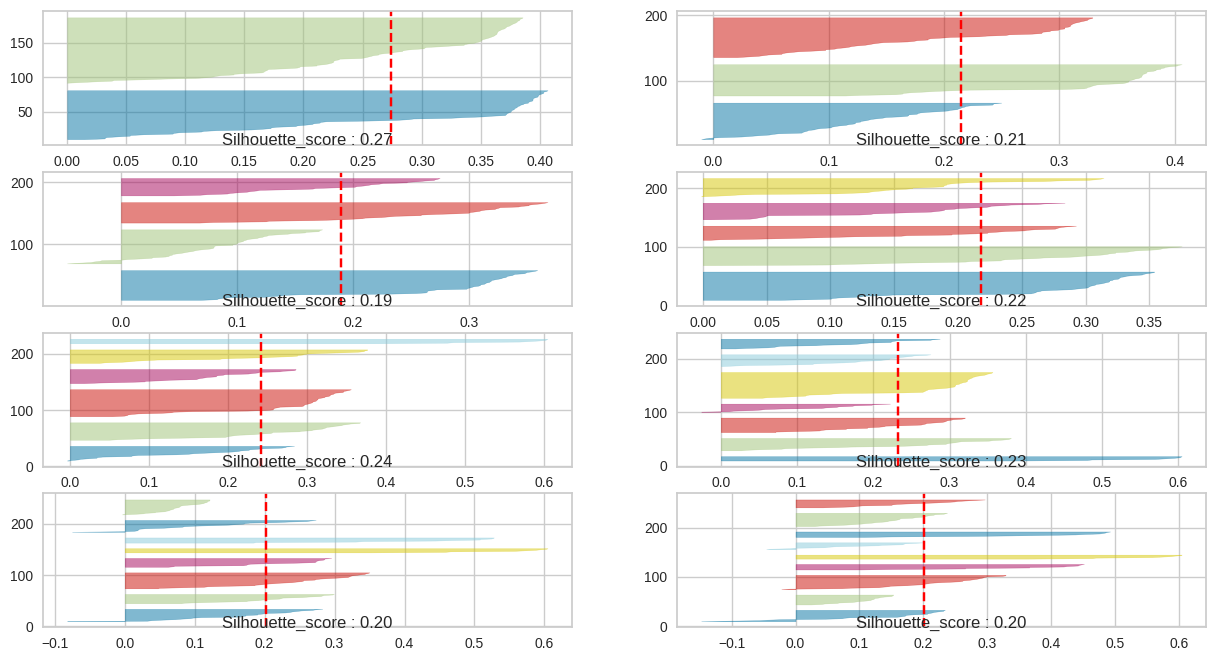

In [39]:
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(4,2, figsize=(15,8))

for k in range(2,10) :
    kmeans=KMeans(n_clusters=k,random_state=0)
    q,mod=divmod(k,2)
    visualizer=SilhouetteVisualizer(kmeans,colors='yellowbrick',ax=ax[q-1][mod])
    visualizer.fit(loading_data_transpose)
    silhouette_score=visualizer.silhouette_score_
    ax[q-1][mod].text(0.5,0,f'Silhouette_score : {silhouette_score:.2f}',transform=ax[q-1][mod].transAxes,ha='center')

plt.show()

Looking at the WCSS graph, we can argue that 4 clusters is definity a reasonable choice. Additionally, we prefer to choose the same amount of clusters for our two algorithms so that we can compare the results.

## n_clusters=2

In [40]:
n_clusters=2

data_pca=data_pca[:,:2]
kmeans = KMeans(n_clusters, random_state = 0)
kmeans.fit(data_pca)
tLabelsPCA= kmeans.labels_
kmeans.fit(loading_data_transpose)
tLabels= kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



### Comparison of the two results :

<ipython-input-41-44a22c6fdbfa>:2: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

<ipython-input-41-44a22c6fdbfa>:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Label-ColorPCA Correspondence:
Label Label 0: purple
Label Label 1: yellow


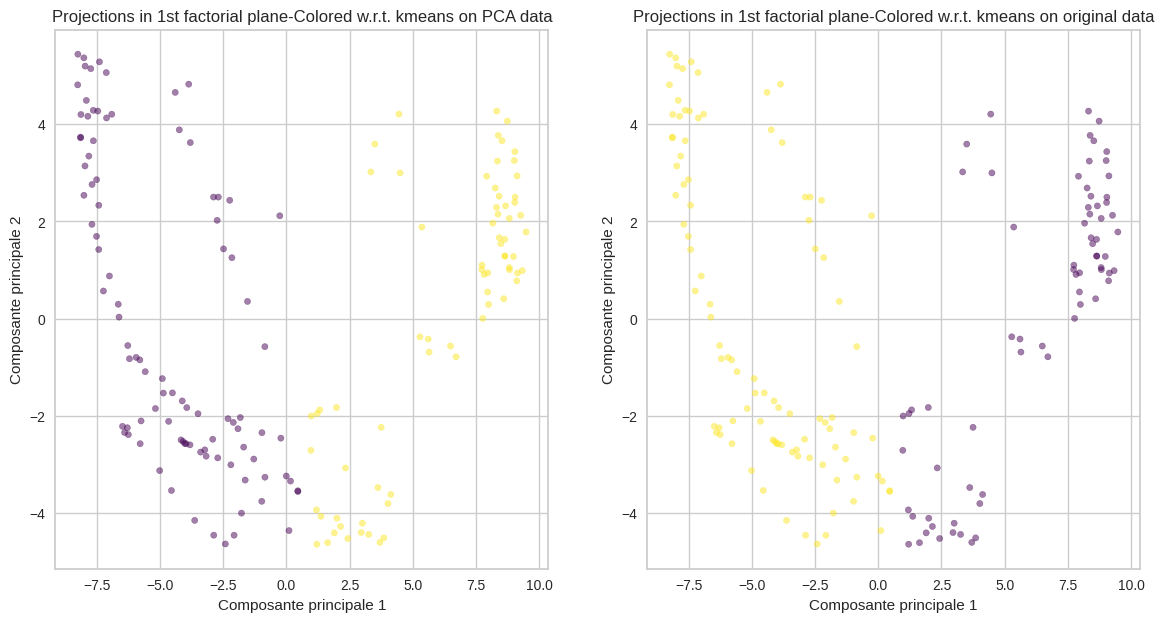

In [41]:
import matplotlib.colors as mcolors
cmap = cm.get_cmap('cool')
cmapv= cm.get_cmap('viridis')

colorsPCA=[cmapv(i/(n_clusters-1)) for i in tLabelsPCA]
colors=[cmapv(i/(n_clusters-1)) for i in tLabels]

label_color_dict2 = {'Label 0':'purple','Label 1':'yellow'}

print("Label-ColorPCA Correspondence:")
for label, color in label_color_dict2.items():
    print(f"Label {label}: {color}")
fig, ax = plt.subplots(1,2,figsize=(14,7))


ax[0].scatter(data_pca[:,0],data_pca[:,1],alpha=0.5,s=20,c=colorsPCA)
ax[0].set_title('Projections in 1st factorial plane-Colored w.r.t. kmeans on PCA data')
ax[0].set_xlabel('Composante principale 1')
ax[0].set_ylabel('Composante principale 2')

ax[1].scatter(data_pca[:,0],data_pca[:,1],alpha=0.5,s=20,c=colors)
ax[1].set_title('Projections in 1st factorial plane-Colored w.r.t. kmeans on original data')
ax[1].set_xlabel('Composante principale 1')
ax[1].set_ylabel('Composante principale 2')

plt.show()

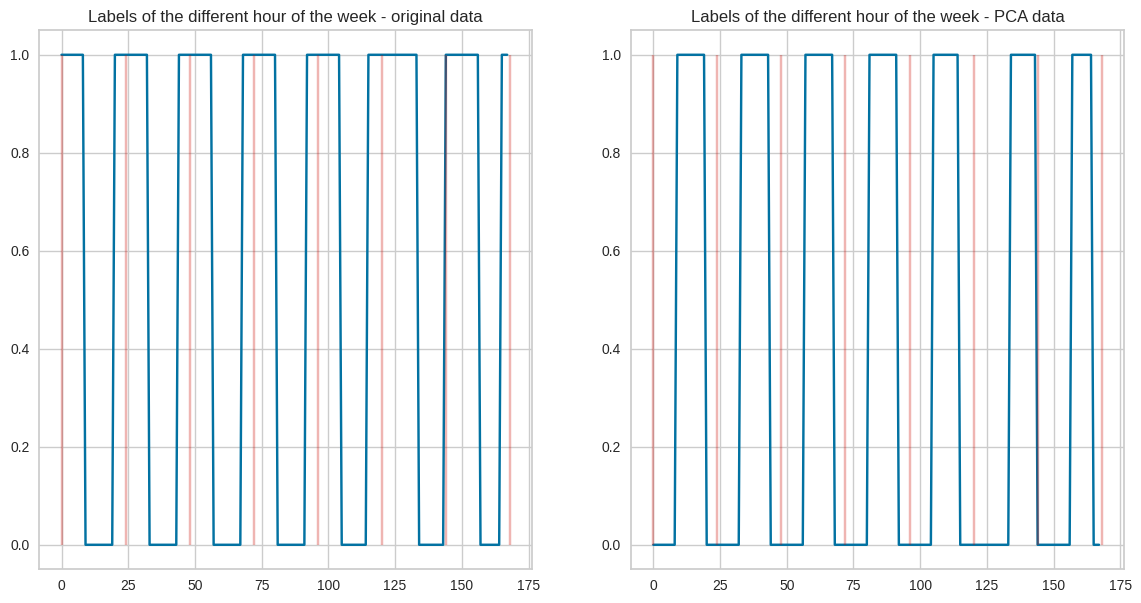

In [42]:
fig, ax =plt.subplots(1,2,figsize=(14,7))
days=np.linspace(0,168,8)

ax[0].plot(tLabels)
ax[0].set_title('Labels of the different hour of the week - original data')
ax[0].vlines(days, 0, n_clusters-1, color='r',alpha=0.3)
ax[1].plot(tLabelsPCA)
ax[1].set_title('Labels of the different hour of the week - PCA data')
ax[1].vlines(days, 0, n_clusters-1, color='r',alpha=0.3)
plt.show()

Performing kmeans with 2 clusters, basically leads us to our gathered vs spread time profiles we've seen before

## n_clusters=4

In [43]:
n_clusters=4

data_pca=data_pca[:,:2]
kmeans = KMeans(n_clusters, random_state = 0)
kmeans.fit(data_pca)
tLabelsPCA= kmeans.labels_
kmeans.fit(loading_data_transpose)
tLabels= kmeans.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



### Comparison of the two results :

Label-ColorPCA Correspondence:
Label Label 3: yellow
Label Label 2: green
Label Label 1: blue
Label Label 0: purple


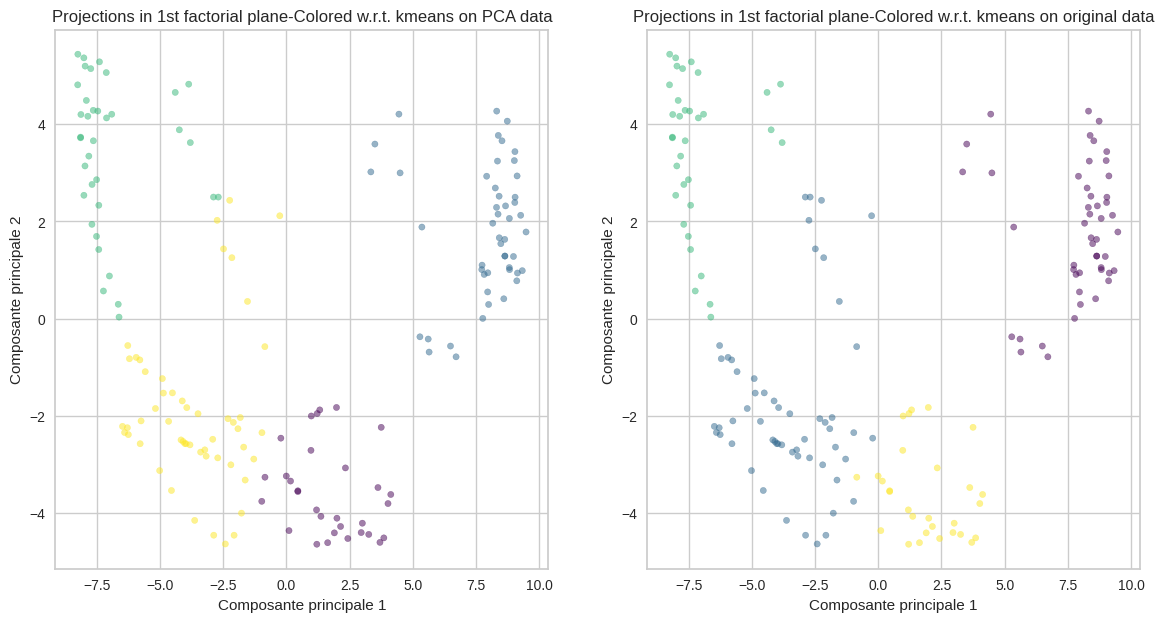

In [44]:
colorsPCA=[cmapv(i/(n_clusters-1)) for i in tLabelsPCA]
colors=[cmapv(i/(n_clusters-1)) for i in tLabels]

label_color_dict = {'Label 3':'yellow','Label 2':'green','Label 1':'blue','Label 0':'purple'}

print("Label-ColorPCA Correspondence:")
for label, color in label_color_dict.items():
    print(f"Label {label}: {color}")
fig, ax = plt.subplots(1,2,figsize=(14,7))


ax[0].scatter(data_pca[:,0],data_pca[:,1],alpha=0.5,s=20,c=colorsPCA)
ax[0].set_title('Projections in 1st factorial plane-Colored w.r.t. kmeans on PCA data')
ax[0].set_xlabel('Composante principale 1')
ax[0].set_ylabel('Composante principale 2')

ax[1].scatter(data_pca[:,0],data_pca[:,1],alpha=0.5,s=20,c=colors)
ax[1].set_title('Projections in 1st factorial plane-Colored w.r.t. kmeans on original data')
ax[1].set_xlabel('Composante principale 1')
ax[1].set_ylabel('Composante principale 2')

plt.show()

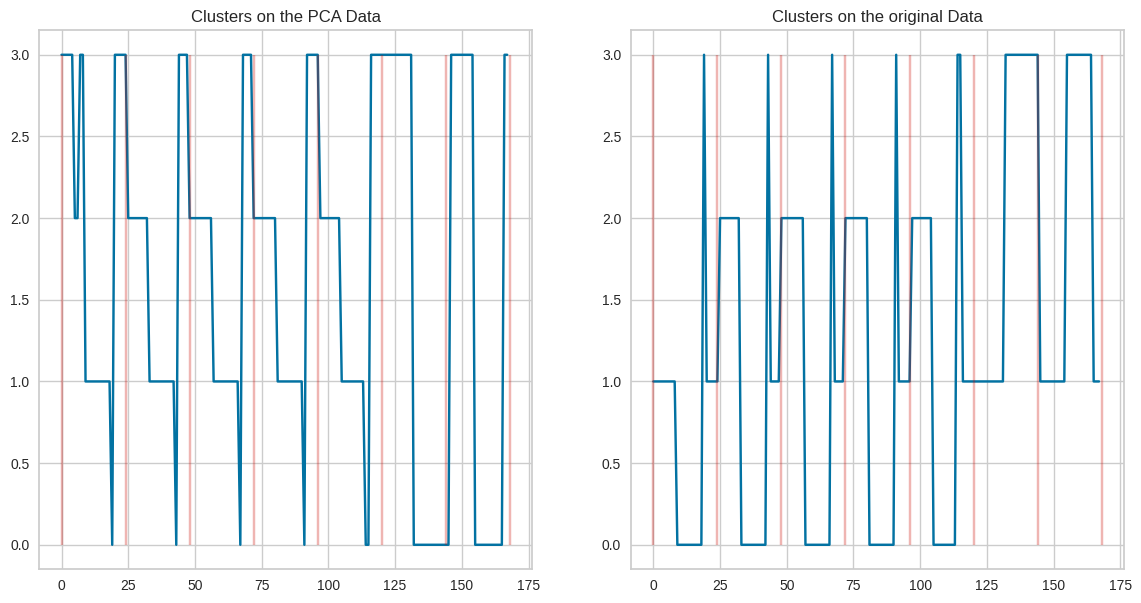

In [45]:
fig, ax =plt.subplots(1,2,figsize=(14,7))
days=np.linspace(0,168,8)

ax[1].plot(tLabels)
ax[1].set_title('Clusters on the original Data')
ax[1].vlines(days, 0, n_clusters-1, color='r',alpha=0.3)
ax[0].plot(tLabelsPCA)
ax[0].set_title('Clusters on the PCA Data')
ax[0].vlines(days, 0, n_clusters-1, color='r',alpha=0.3)
plt.show()

We'll use these graphs on the ones in the below section to understand what the clusters represent

#### Hour profiles on original data

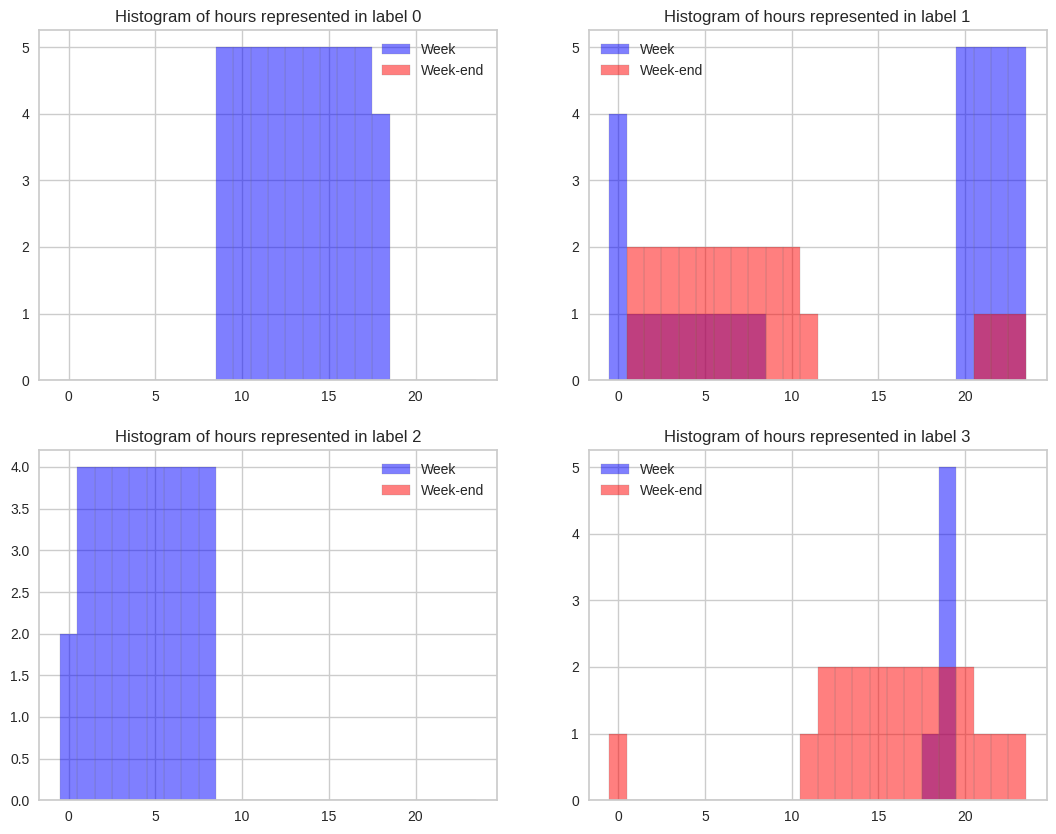

In [46]:
hour_bins = np.arange(25) - 0.5
fig ,ax= plt.subplots(2,2,figsize=(13,10))

for i,label in enumerate(np.unique(tLabels)):
    row = i // 2
    col = i % 2
    indexes = np.where(tLabels == label)[0]
    week_hours = [index % 24 for index in indexes if index <= 24 * 5]
    week_end_hours = [index % 24 for index in indexes if index > 24 * 5]
    ax[row,col].hist(week_hours, bins=hour_bins, edgecolor='grey',color='blue',alpha=0.5,label='Week')
    ax[row,col].hist(week_end_hours, bins=hour_bins, edgecolor='grey',color='red',alpha=0.5,label='Week-end')
    ax[row,col].set_title(f'Histogram of hours represented in label {label}')
    ax[row, col].legend()
plt.show()

Kmeans algorithm makes acts a bit differently depending on which data it is trained. On the original data it is pretty clear :

* label 0 : Week evenings
* label 1 : Working hours
* label 2 : Week nights
* label 3 : Week-end

#### Hour profiles on PCA data

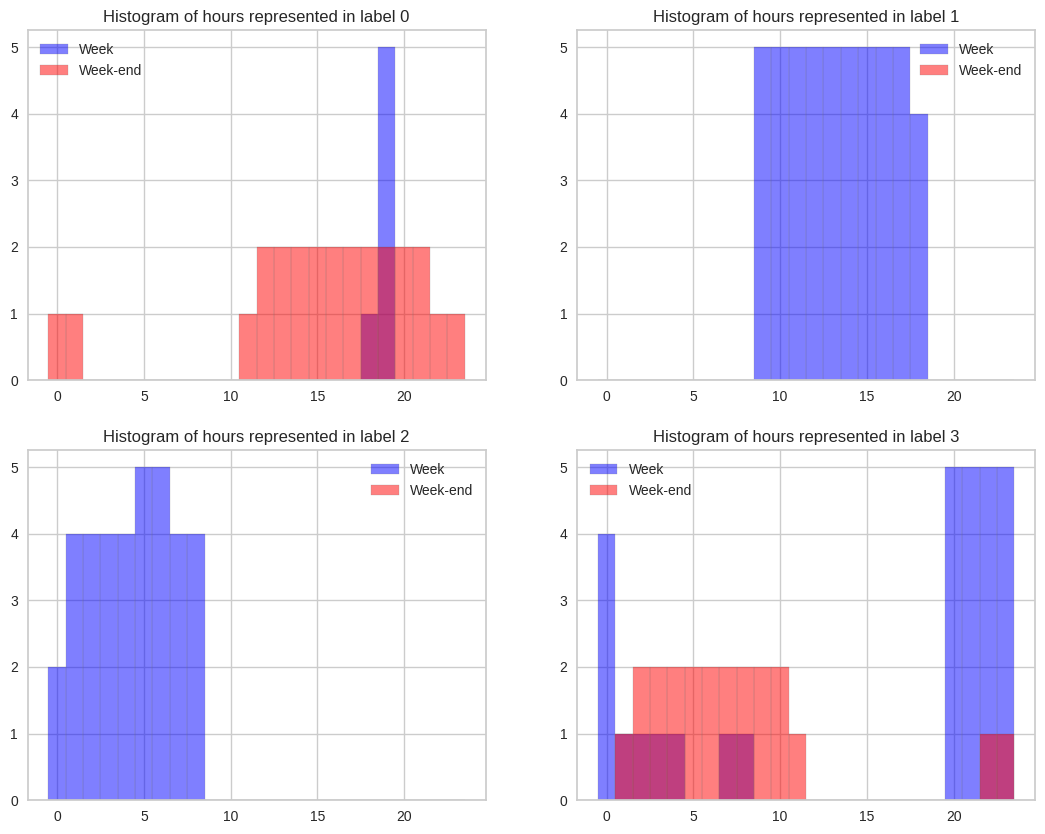

In [47]:
hour_bins = np.arange(25) - 0.5
fig ,ax= plt.subplots(2,2,figsize=(13,10))

for i,label in enumerate(np.unique(tLabelsPCA)):
    row = i // 2
    col = i % 2
    indexes = np.where(tLabelsPCA == label)[0]
    week_hours = [index % 24 for index in indexes if index <= 24 * 5]
    week_end_hours = [index % 24 for index in indexes if index > 24 * 5]
    ax[row,col].hist(week_hours, bins=hour_bins, edgecolor='grey',color='blue',alpha=0.5,label='Week')
    ax[row,col].hist(week_end_hours, bins=hour_bins, edgecolor='grey',color='red',alpha=0.5,label='Week-end')
    ax[row,col].set_title(f'Histogram of hours represented in label {label}')
    ax[row, col].legend()
plt.show()

On the PCA data, we get the same profiles as before for labels 1 and 2 but the precedent groups corresponding to labels 0 and 3 are mixed so that:

* label 0 corresponds to 6-7pm after work hours and day hours of the week-end which is interesting because these hours correspond to day "go out" time.
* label 1 : Working hours
* label 2 : Week nights
* label 3 corresponds to week days evenings (between 8pm and midnight) and week-end nights during which people are also "going out" for nightime.


# <FONT COLOR="Red">PCA on original data   </font>

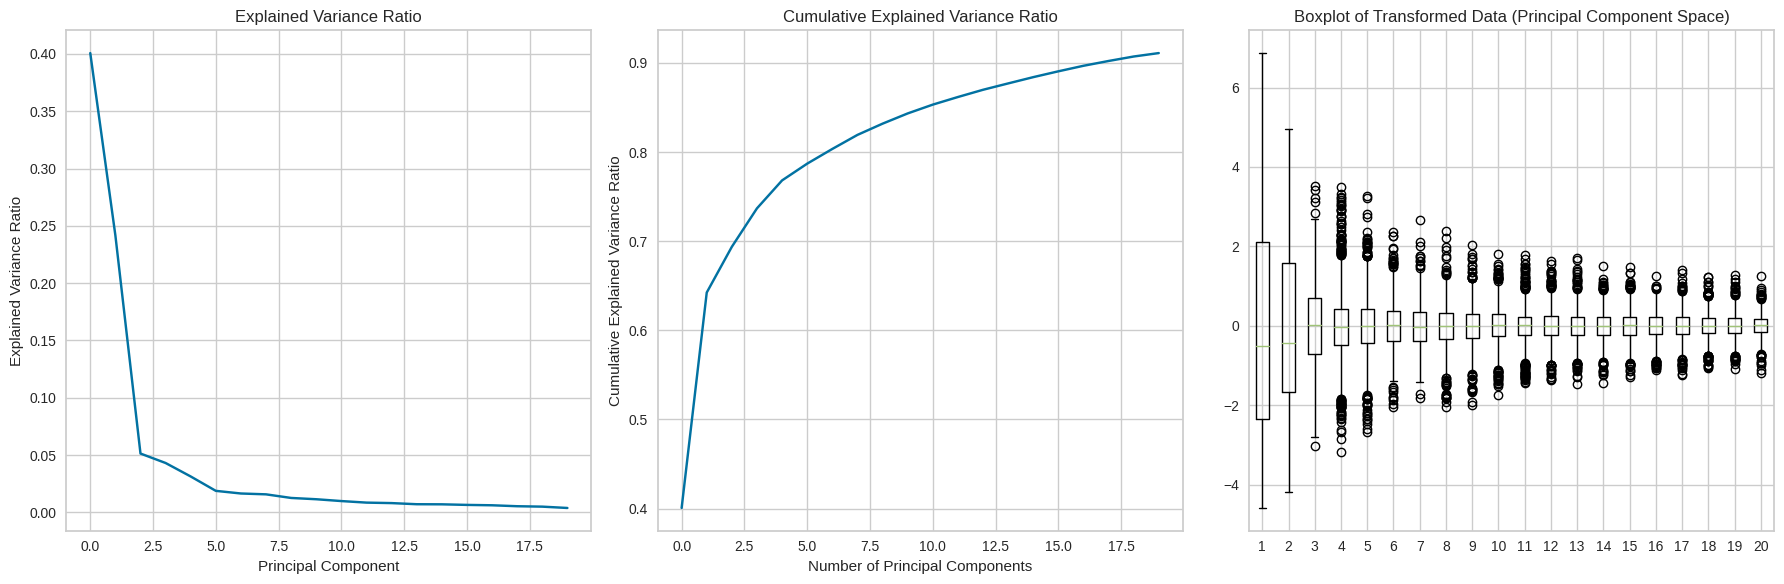

In [48]:
pca2 = PCA(n_components=20)
pca2.fit(loading_data)
data_pca2 = pca2.transform(loading_data)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Explained variance ratio
axes[0].plot(pca2.explained_variance_ratio_)
axes[0].set_title('Explained Variance Ratio')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')

# Cumulative explained variance ratio
axes[1].plot(np.cumsum(pca2.explained_variance_ratio_))
axes[1].set_title('Cumulative Explained Variance Ratio')
axes[1].set_xlabel('Number of Principal Components')
axes[1].set_ylabel('Cumulative Explained Variance Ratio')

# Boxplot of the transformed data in the principal component space
axes[2].boxplot(data_pca2)
axes[2].set_title('Boxplot of Transformed Data (Principal Component Space)')

plt.tight_layout()
plt.show()

In this PCA the choice of 2 principal components seems reasonable

# Interpretation of the first principal components

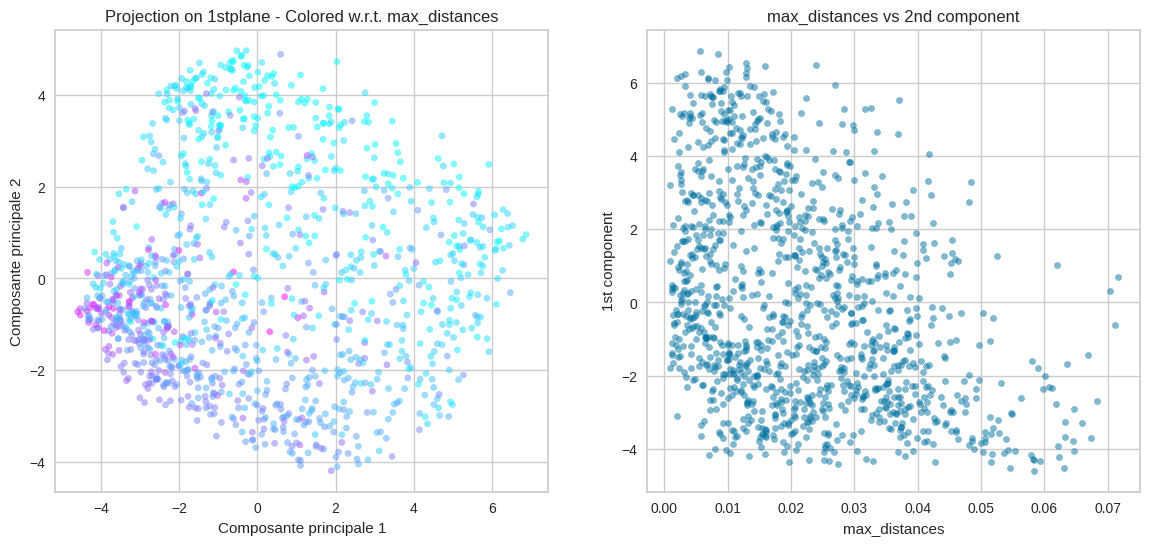

Correlation coefficient: -0.47526555633429823


In [49]:
fig, ax=plt.subplots(1,2,figsize=(14,6))

norm = plt.Normalize(vmin=min(max_distances), vmax=max(max_distances))
colors=[cmap(norm(distance)) for distance in max_distances]
ax[0].scatter(data_pca2[:,0],data_pca2[:,1],alpha=0.5,s=20,c=colors)
ax[0].grid(True)
ax[0].set_title('Projection on 1stplane - Colored w.r.t. max_distances')
ax[0].set_xlabel('Composante principale 1')
ax[0].set_ylabel('Composante principale 2')

ax[1].scatter(max_distances,data_pca2[:,0],alpha=0.5,s=20)
ax[1].set_title('max_distances vs 2nd component')
ax[1].set_xlabel('max_distances')
ax[1].set_ylabel('1st component')
plt.show()

correlation_coefficient = np.corrcoef(max_distances, data_pca2[:,1])[0, 1]
print("Correlation coefficient:", correlation_coefficient)

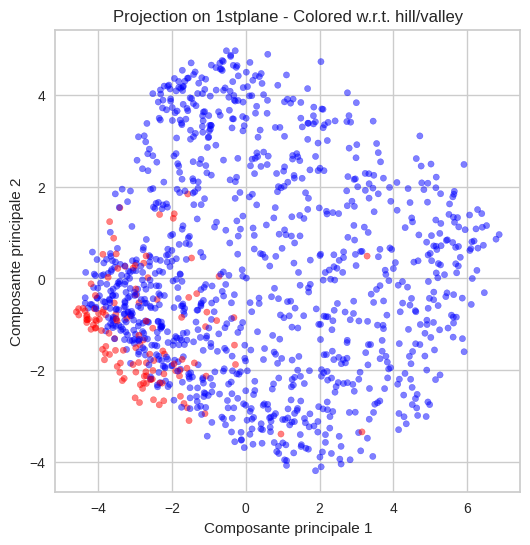

In [50]:
colors=['red' if m else 'blue' for m in coord.bonus == 1]

plt.figure(figsize=(6,6))
plt.scatter(data_pca2[:,0],data_pca2[:,1],alpha=0.5,s=20,c=colors)
plt.title('Projection on 1stplane - Colored w.r.t. hill/valley')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')

plt.show()

Our first insights on the data were not really good : the distance from the Seine and the altitude variables are not capable of explaining the
variance between station profiles.

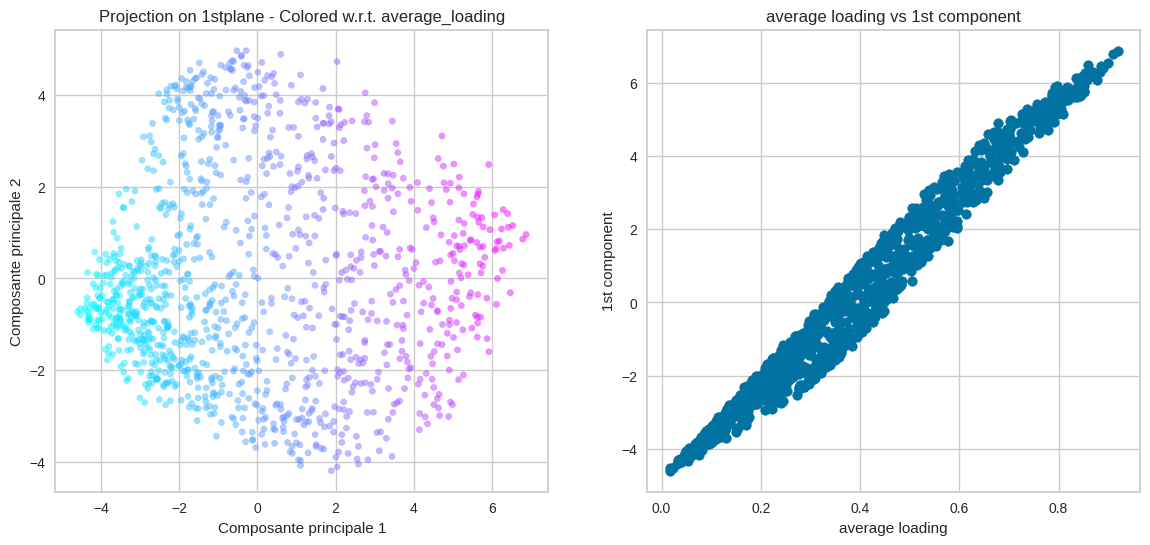

Correlation coefficient: 0.9850802568399248


In [51]:
fig, ax=plt.subplots(1,2,figsize=(14,6))

norm = plt.Normalize(vmin=min(average_loading), vmax=max(average_loading))
colors=[cmap(norm(average)) for average in average_loading]

ax[0].scatter(data_pca2[:,0],data_pca2[:,1],alpha=0.5,s=20,c=colors)
ax[0].grid(True)
ax[0].set_title('Projection on 1stplane - Colored w.r.t. average_loading')
ax[0].set_xlabel('Composante principale 1')
ax[0].set_ylabel('Composante principale 2')

ax[1].scatter(average_loading,data_pca2[:,0])
ax[1].set_title('average loading vs 1st component')
ax[1].set_xlabel('average loading')
ax[1].set_ylabel('1st component')
plt.show()

correlation_coefficient = np.corrcoef(average_loading, data_pca2[:,0])[0, 1]
print("Correlation coefficient:", correlation_coefficient)

Average loading seems to be a really good criteria for discriminating the variables, it is very correlated to our first component

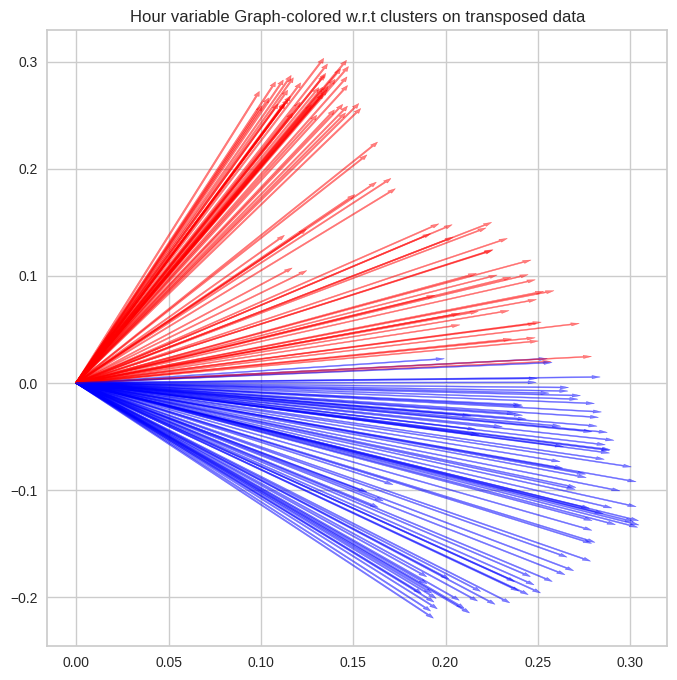

In [52]:
coord1=pca2.components_[0]*np.sqrt(pca2.explained_variance_[0])
coord2=pca2.components_[1]*np.sqrt(pca2.explained_variance_[1])

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

mask = ['red' if label in [0,1] else 'blue' for label in tLabelsPCA]

k=0
for i, j in zip(coord1, coord2):
    ax.arrow(0, 0, i, j,color=mask[k],alpha=0.5)
    k+=1
plt.title('Hour variable Graph-colored w.r.t clusters on transposed data')
plt.show()

We observe that all the arrows are pointing towards positive values on the first components, all the hourly loading variables are positively correlated to the first component. This component most likely represent some weighted average loading over time.

Also, when we color the arrows w.r.t. the labels obtained when performing clustering on the transposed data (picking blue for Labels 0,1 and red for labels 2,3), we clearly see that the labels are correlated to the contribution to the second component.

This makes sence because individuals labeled 0,1 and labeled 2,3 are separated along the axis of the first component of transposed PCA, and theoretically if we only use euclidian distance while performing PCA : $ XX^Tv=\lambda v \Leftrightarrow X^TX(X^Tv)=\lambda (X^Tv)$  so the principal components of the transposed PCA correspond to the principal axis of the regular PCA. In this case, the first principal component of the PCA on transposed data corresponds to the second principal axis of the PCA on original data.

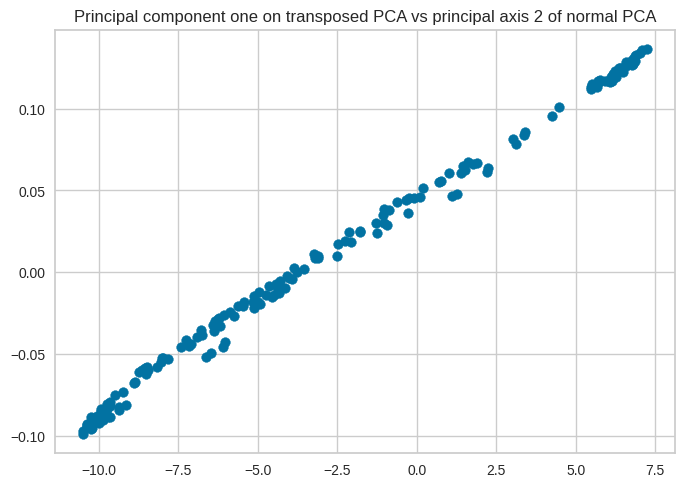

correlation coefficient : 0.9978592175770185


In [53]:
plt.scatter(loading_data_transpose@pca.components_[0], pca2.components_[1]) # loading_transpose@pca.components_[0]=data_pca[:,0]
plt.title("Principal component one on transposed PCA vs principal axis 2 of normal PCA")
plt.show()
correlation_coefficient = np.corrcoef(data_pca[:,0], pca2.components_[1])[0, 1]
print(f"correlation coefficient : {correlation_coefficient}")

What we will keep in mind is that hours contributing positively to the second component correspond to those labeled 0,1 in our previous clustering and the hours contributing negatively are those which were labeled 2,3 (see interpretation of these labels above).

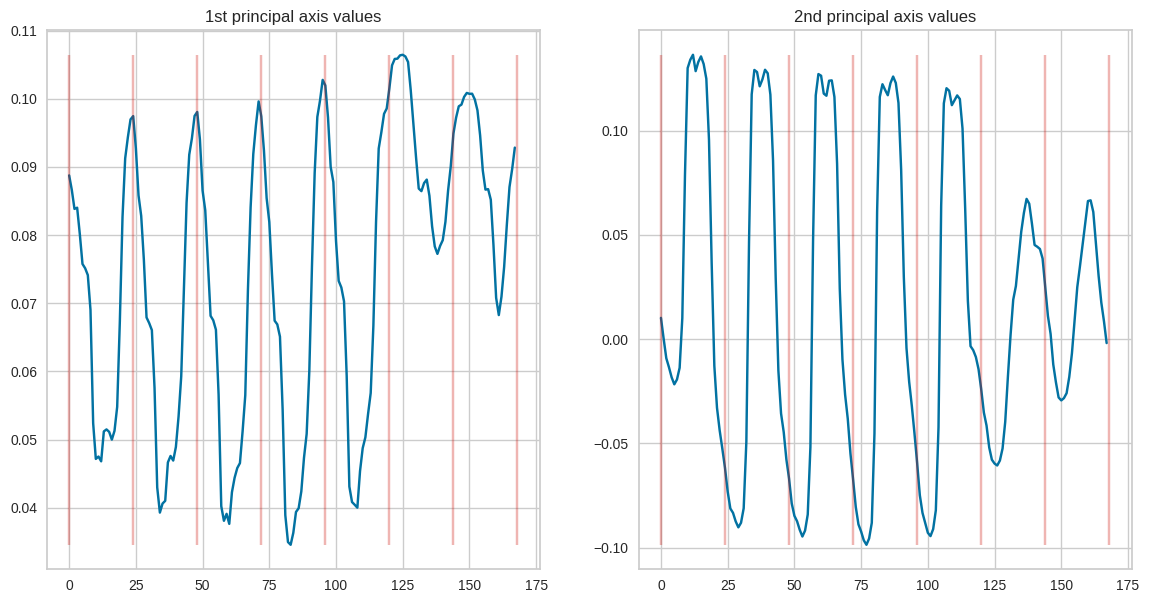

In [54]:
fig, ax = plt.subplots(1,2, figsize=(14,7))

ax[0].plot(pca2.components_[0])
ax[0].vlines(days,min(pca2.components_[0]), max(pca2.components_[0]), color='r',alpha=0.3)
ax[0].set_title('1st principal axis values')

ax[1].plot(pca2.components_[1])
ax[1].vlines(days, min(pca2.components_[1]),max(pca2.components_[1]), color='r',alpha=0.3)
ax[1].set_title('2nd principal axis values')

plt.show()

We now extract the structure of this principal axis, examinating exactly which hours are contributing the most to our axis.

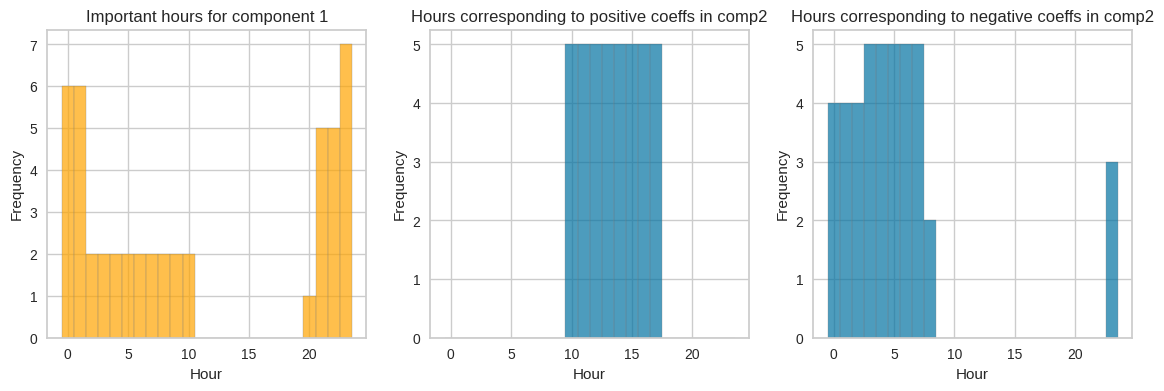

In [55]:
high_hours2 = []
high_hours=[]
low_hours=[]

for i, coeff in enumerate(pca2.components_[0]):
    if coeff > 0.09:
        high_hours.append(i%24)

for i, coeff in enumerate(pca2.components_[1]):
    if coeff > 0.1:
        high_hours2.append(i%24)
    elif coeff<-0.05:
        low_hours.append(i%24)

fig, ax = plt.subplots(1, 3, figsize=(14, 4))

ax[0].hist(high_hours, bins=hour_bins, edgecolor='grey',alpha=0.7,color='orange')
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Important hours for component 1')

ax[1].hist(high_hours2, bins=hour_bins, edgecolor='grey',alpha=0.7)
ax[1].set_xlabel('Hour')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Hours corresponding to positive coeffs in comp2')

ax[2].hist(low_hours, bins=hour_bins, edgecolor='grey',alpha=0.7)
ax[2].set_xlabel('Hour')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Hours corresponding to negative coeffs in comp2')

plt.show()

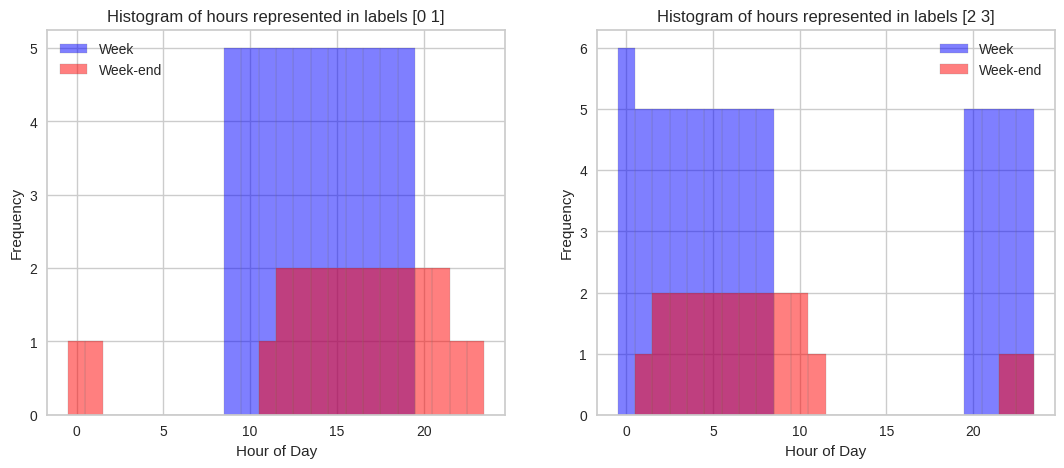

In [56]:
fig ,ax= plt.subplots(1,2,figsize=(13,5))

for i in range(0, len(np.unique(tLabelsPCA)), 2):
    labels = np.unique(tLabelsPCA)[i:i+2]
    indexes = np.where(np.isin(tLabelsPCA, labels))[0]
    week_hours = [index % 24 for index in indexes if index <= 24 * 5]
    week_end_hours = [index % 24 for index in indexes if index > 24 * 5]
    ax[i//2].hist(week_hours, bins=hour_bins, edgecolor='grey', color='blue', alpha=0.5, label='Week')
    ax[i//2].hist(week_end_hours, bins=hour_bins, edgecolor='grey', color='red', alpha=0.5, label='Week-end')
    ax[i//2].set_title(f'Histogram of hours represented in labels {labels}')
    ax[i//2].set_xlabel('Hour of Day')
    ax[i//2].set_ylabel('Frequency')
    ax[i//2].legend()
plt.show()

Here we used two methods to make a summary of the hours contributing to the second component.

For the first histograms, the threshold choice cuts out the hours during the week-end because their contribution to the second principal component is smaller.

The following histograms show the hours labeled 0,1 on the one hand and the ones labeled 2,3 on the other hand, which we know are a good indicator of the positive or negative contribution to the second principal component.

We are trying to see if we can build a simpler variable approximating well the second principal component by using the hours obtained after thresholding.

In [62]:
night = [0,1,2,3,4,5,6,7,8,21,22,23]
day =[10,11,12,13,14,15,16,17]

filter_c1=np.array([2 if i%24 in night else 1 for i in list(range(168))])
filter_c2=np.array([1 if i%24 in day else -1 if i%24 in night else 0 for i in list(range(168))])
filter_labels=np.array([1 if label in [0,1] else -1 for label in tLabelsPCA])


average_loading=loading_data.mean(axis=1)
c1_average=(loading_data * filter_c1[:, np.newaxis].T).mean(axis=1)
c2_average=(loading_data * filter_c2[:, np.newaxis].T).mean(axis=1)
labels_average=(loading_data * filter_labels[:, np.newaxis].T).mean(axis=1)
np.shape(c2_average)





(1189,)

### 1st principal component approximation

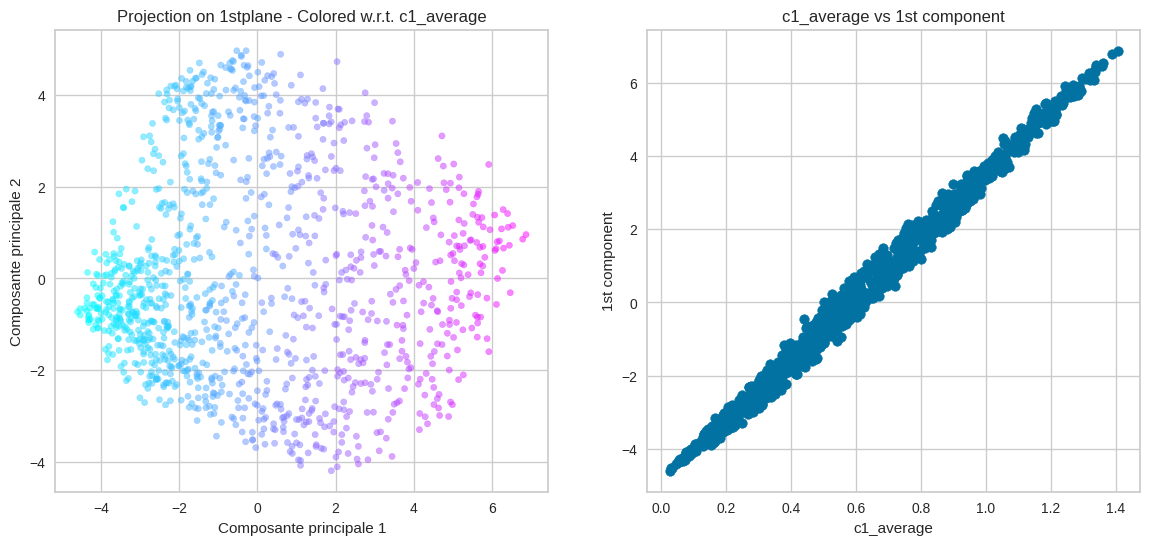

Correlation coefficient: 0.9960062357277479


In [63]:
fig, ax=plt.subplots(1,2,figsize=(14,6))

norm = plt.Normalize(vmin=min(c1_average), vmax=max(c1_average))
colors=[cmap(norm(average)) for average in c1_average]

ax[0].scatter(data_pca2[:,0],data_pca2[:,1],alpha=0.5,s=20,c=colors)
ax[0].set_title('Projection on 1stplane - Colored w.r.t. c1_average')
ax[0].set_xlabel('Composante principale 1')
ax[0].set_ylabel('Composante principale 2')

ax[1].scatter(c1_average,data_pca2[:,0])
ax[1].set_title('c1_average vs 1st component')
ax[1].set_xlabel('c1_average')
ax[1].set_ylabel('1st component')
plt.show()

correlation_coefficient = np.corrcoef(c1_average, data_pca2[:,0])[0, 1]
print("Correlation coefficient:", correlation_coefficient)

The c1_average variable created from the c1_filter refines our understanding of the first component : More than just an average over time,  **represents a weighted average where night hours are given more weight**.

### 2nd principal component approximation

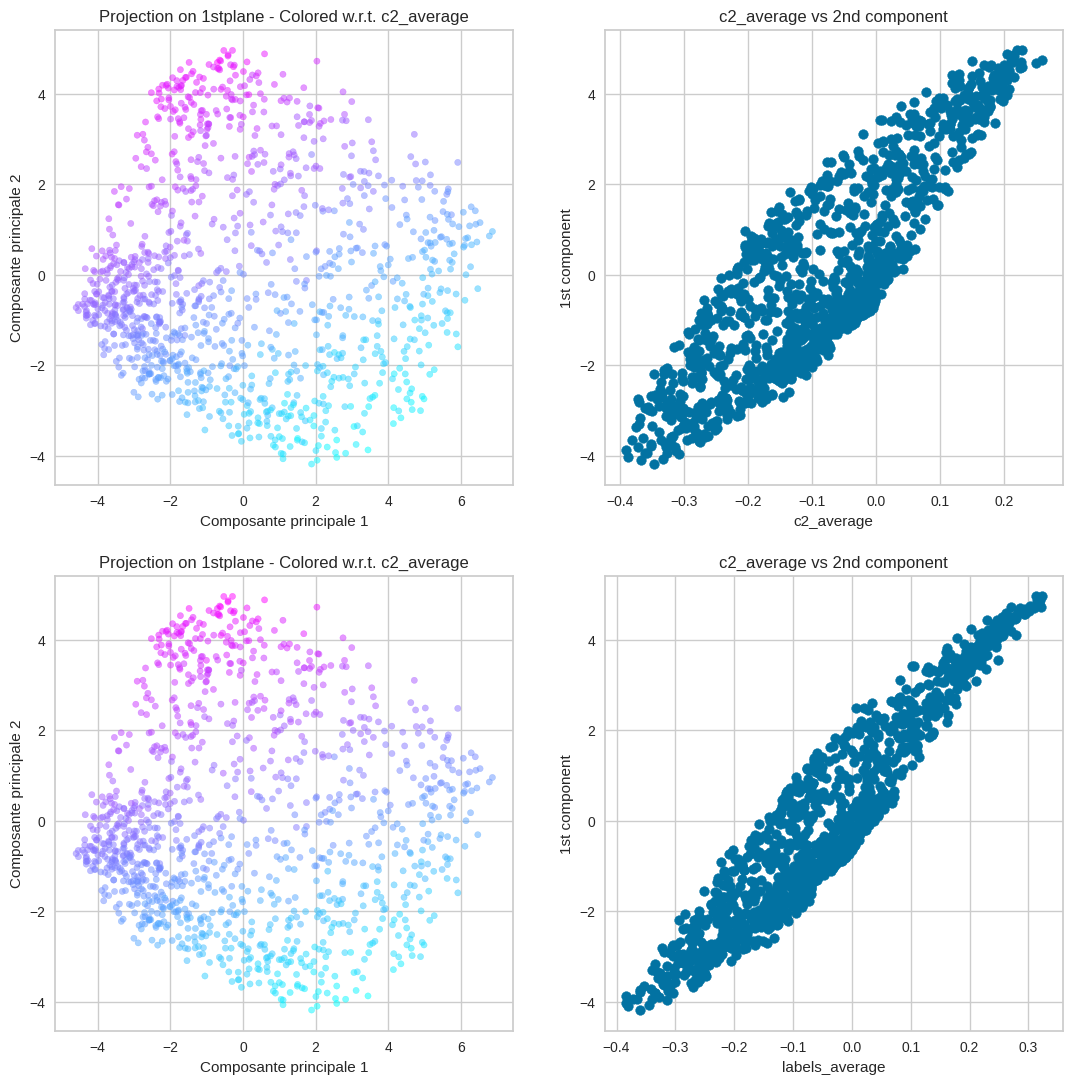

Correlation coefficient between principal component 2 and c2_average : 0.8588524472777876
Correlation coefficient between principal component 2 and labels_average : 0.9397288536944959


In [64]:
fig, ax=plt.subplots(2,2,figsize=(13,13))


norm = plt.Normalize(vmin=min(c2_average), vmax=max(c2_average))
colors=[cmap(norm(average)) for average in c2_average]

ax[0,0].scatter(data_pca2[:,0],data_pca2[:,1],alpha=0.5,s=20,c=colors)
ax[0,0].set_title('Projection on 1stplane - Colored w.r.t. c2_average')
ax[0,0].set_xlabel('Composante principale 1')
ax[0,0].set_ylabel('Composante principale 2')

ax[0,1].scatter(c2_average,data_pca2[:,1])
ax[0,1].set_title('c2_average vs 2nd component')
ax[0,1].set_xlabel('c2_average')
ax[0,1].set_ylabel('1st component')

norm = plt.Normalize(vmin=min(labels_average), vmax=max(labels_average))
colors=[cmap(norm(average)) for average in labels_average]

ax[1,0].scatter(data_pca2[:,0],data_pca2[:,1],alpha=0.5,s=20,c=colors)
ax[1,0].set_title('Projection on 1stplane - Colored w.r.t. c2_average')
ax[1,0].set_xlabel('Composante principale 1')
ax[1,0].set_ylabel('Composante principale 2')

ax[1,1].scatter(labels_average,data_pca2[:,1])
ax[1,1].set_title('c2_average vs 2nd component')
ax[1,1].set_xlabel('labels_average')
ax[1,1].set_ylabel('1st component')

plt.show()

print(f"Correlation coefficient between principal component 2 and c2_average : {np.corrcoef(c2_average, data_pca2[:,1])[0, 1]}")
print(f"Correlation coefficient between principal component 2 and labels_average : {np.corrcoef(labels_average, data_pca2[:,1])[0, 1]}")

Unfortunately, though the c2_average variable has a simpler representation, it doesn't approximate the second principal component well enough.

The labels_average created from the labels_filter refines our interpretation of principal component 2 : it is a weighted sum where hours labeled 0,1 in our hours clustering are given positive weights and where hours labeled 2,3 are given equal negative weights. **It separates stations which are more loaded during working hours and go-out time and less loaded during night from the stations following the opposite movement**

### We may now use some clustering algorithms to discriminate individuals, and identify different user profiles.

# <FONT COLOR="Red">Clustering on original data   </font>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

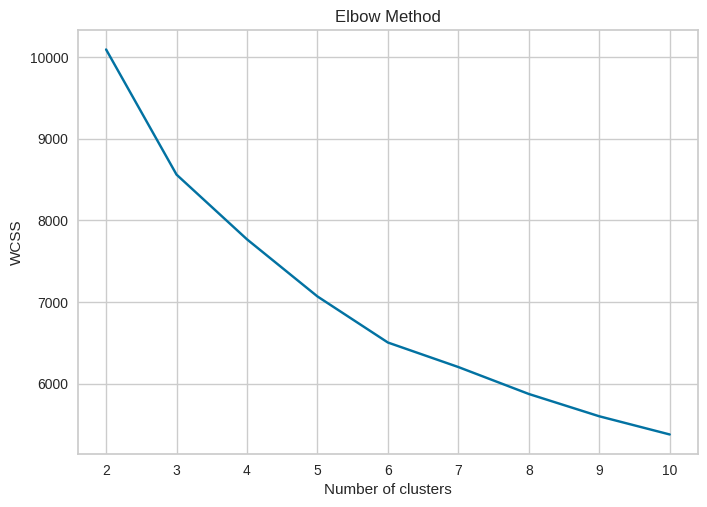

In [65]:
wcss = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(loading_data_transpose)
    wcss.append(kmeans.inertia_)  # inertia_ gives the WCSS value

plt.plot(range(2, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

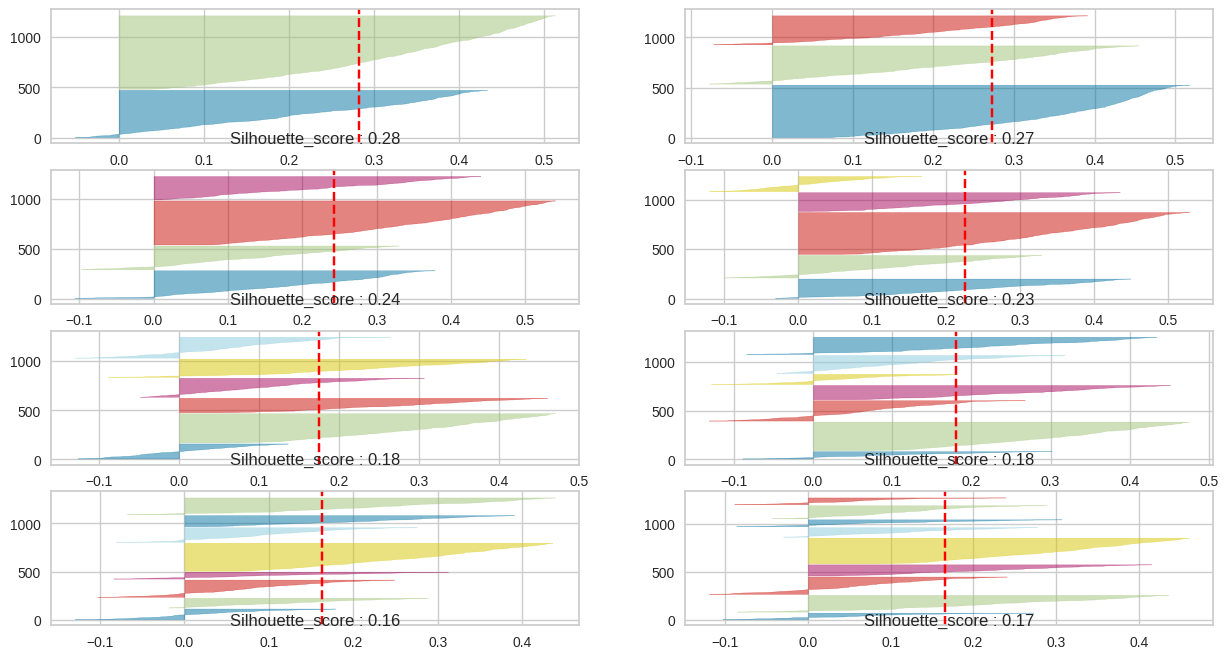

In [66]:
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(4,2, figsize=(15,8))

for k in range(2,10) :
    kmeans=KMeans(n_clusters=k,random_state=0)
    q,mod=divmod(k,2)
    visualizer=SilhouetteVisualizer(kmeans,colors='yellowbrick',ax=ax[q-1][mod])
    visualizer.fit(loading_data)
    silhouette_score=visualizer.silhouette_score_
    ax[q-1][mod].text(0.5,0,f'Silhouette_score : {silhouette_score:.2f}',transform=ax[q-1][mod].transAxes,ha='center')

plt.show()

Here, the silhouette score graph suggets we don't take more than 4 clusters since we have a huge loss in definability for 5 clusters and more.
The WCSS graph doesn't showcase any sharp elbow, There's not much that can set us choosing whether we consider 3 or 4 clusters.

# 3 Clusters

In [67]:
n_clusters=3
kmeans = KMeans(n_clusters, random_state = 0)
kmeans.fit(loading_data)
Labels3= kmeans.labels_
coord['Labels3'] = Labels3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



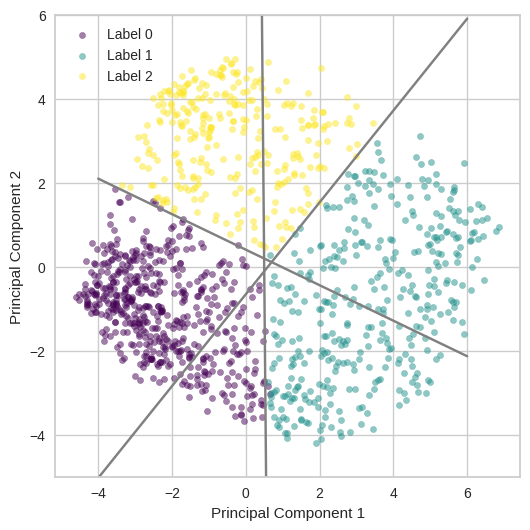

In [68]:
# Create a legend mapping label to color
norm = plt.Normalize(vmin=min(Labels3), vmax=max(Labels3))
colors=[cmapv(norm(label)) for label in set(Labels3)]
legend_dict = {label: color for label, color in zip(set(Labels3), colors)}

from sklearn.svm import SVC

indices = np.isin(Labels3, [0, 1])
X0 = data_pca2[indices, :2]
Y0 = Labels3[indices]

indices = np.isin(Labels3, [1, 2])
X1 = data_pca2[indices, :2]
Y1 = Labels3[indices]

indices = np.isin(Labels3, [0, 2])
X2 = data_pca2[indices, :2]
Y2 = Labels3[indices]

svc=SVC(kernel='linear')
svc.fit(X0,Y0)
xx = np.linspace(-4, 6)
w = svc.coef_[0]
y0 = (-w[0] / w[1]) * xx - (svc.intercept_[0]) / w[1]

svc.fit(X1,Y1)
w = svc.coef_[0]
y1 = (-w[0] / w[1]) * xx - (svc.intercept_[0]) / w[1]

svc.fit(X2,Y2)
w = svc.coef_[0]
y2 = (-w[0] / w[1]) * xx - (svc.intercept_[0]) / w[1]

plt.figure(figsize=(6,6))
for label in set(Labels3):
    indices = Labels3 == label
    plt.scatter(data_pca2[indices, 0], data_pca2[indices, 1], alpha=0.5, s=20, color=legend_dict[label], label=f'Label {label}')

plt.ylim(-5, 6)
plt.plot(xx,y0,color='grey')
plt.plot(xx,y1,color='grey')
plt.plot(xx,y2,color='grey')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add legend
plt.legend()
plt.show()

We can see that the clusters obtained by K-means are well separated when represented in the principal components plane :

* The first principal component seem to be whats separating the class 0 individuals from class 1.
* The difference between the two principal components seem to separate class 0 from 2
* The sum of principal components seem to separates classes 1 and 2.

### Separation between class 0 and 1 with along first principal axis

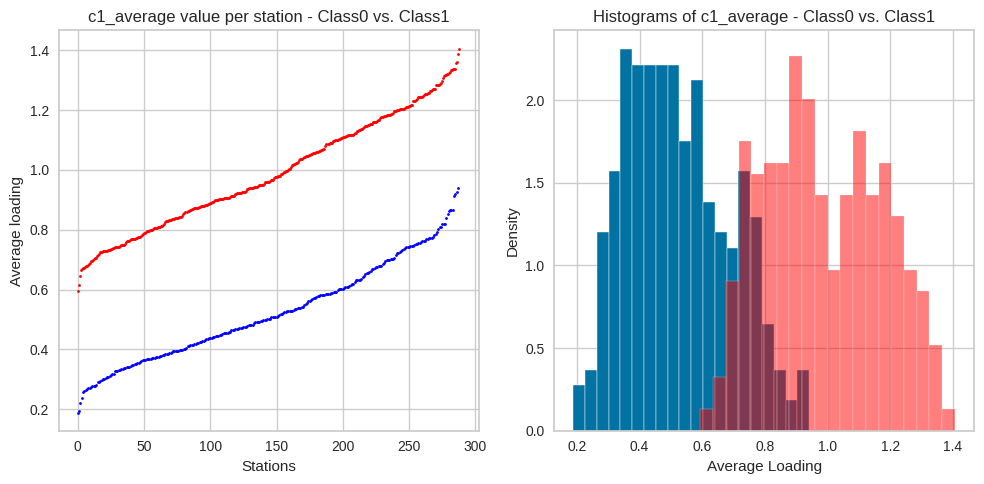

In [69]:
loading_1=loading_data[Labels3==1]
loading_2=loading_data[Labels3==2]

meanR_1 = (loading_1 * filter_c1[:, np.newaxis].T).mean(axis=1)
meanR_2 = (loading_2 * filter_c1[:, np.newaxis].T).mean(axis=1)
meanR_1_sorted = np.sort(meanR_1)
meanR_2_sorted = np.sort(meanR_2)


fig, ax =plt.subplots(1,2,figsize=(10,5))
ax[0].plot(meanR_2_sorted,marker='o',linestyle='None',color='blue',markersize=2)
ax[0].plot(np.linspace(0, len(meanR_2), len(meanR_1)),meanR_1_sorted,marker='o',linestyle='None',color='red',markersize=2)
ax[0].set_xlabel('Stations')
ax[0].set_ylabel('Average loading')
ax[0].set_title("c1_average value per station - Class0 vs. Class1")

ax[1].hist(meanR_2,bins=20,density=True)
ax[1].hist(meanR_1,bins=20,color='red',density=True,alpha=0.5)
ax[1].set_title('Histograms of c1_average - Class0 vs. Class1')
ax[1].set_xlabel('Average Loading')
ax[1].set_ylabel('Density')
plt.tight_layout()
plt.show()

### Separation between class 0 and 2 / between 1 and 2 with along diagonal axis

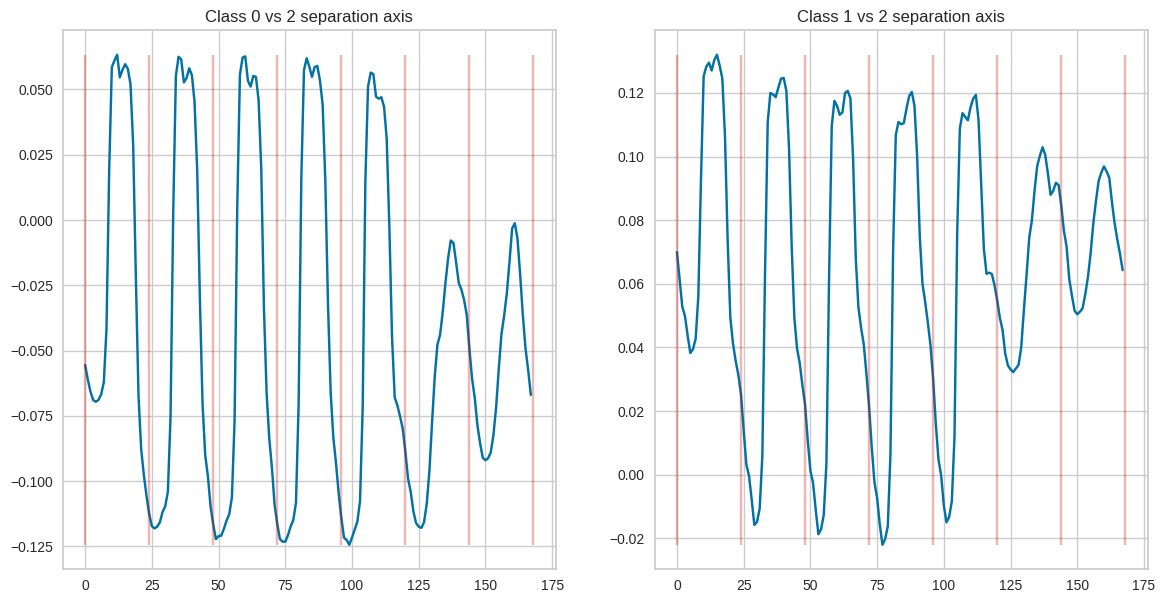

In [70]:
axis0_2=1/np.linalg.norm(pca2.components_[1]-pca2.components_[0])*(pca2.components_[1]-pca2.components_[0])
axis1_2=1/np.linalg.norm(pca2.components_[0]+pca2.components_[1])*(pca2.components_[0]+pca2.components_[1])

fig, ax = plt.subplots(1,2, figsize=(14,7))

ax[0].plot(axis0_2)
ax[0].vlines(days,min(axis0_2), max(axis0_2), color='r',alpha=0.3)
ax[0].set_title('Class 0 vs 2 separation axis')

ax[1].plot(axis1_2)
ax[1].vlines(days, min(axis1_2),max(axis1_2), color='r',alpha=0.3)
ax[1].set_title('Class 1 vs 2 separation axis')

plt.show()

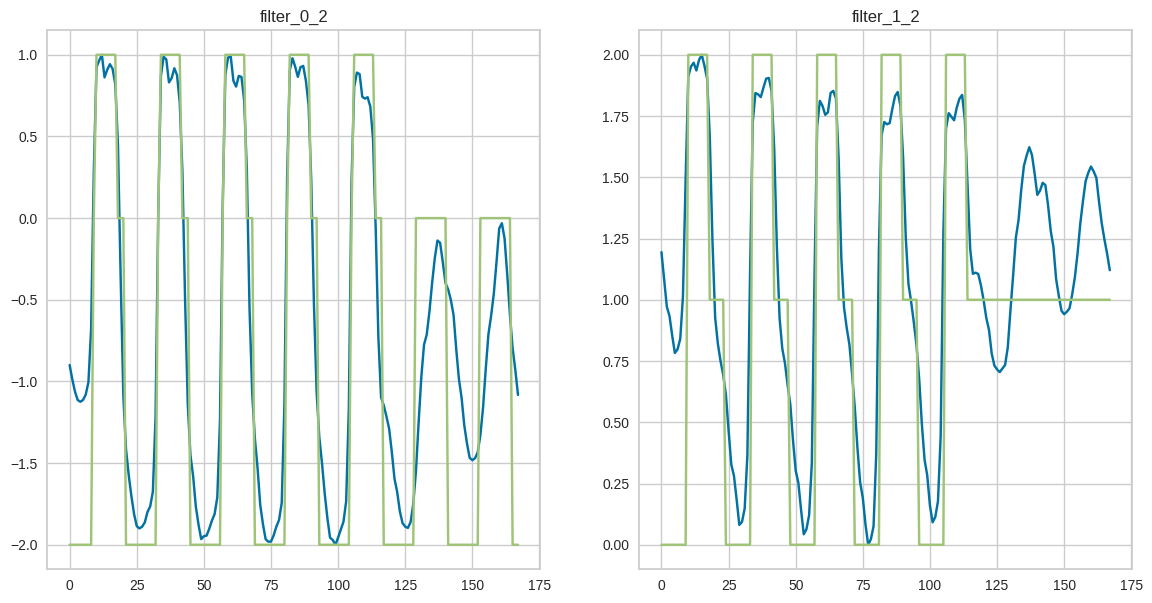

In [71]:
filter_0_2=np.array([-2 if i%24 in night else 1 if (i%24 in day and i//24<5) else 0 for i in list(range(168))])
evening=[18,19,20,21,22,23]
night=[0,1,2,3,4,5,6,7,8]
filter_1_2=np.array([1 if (i%24 in evening or i>115) else 2 if i%24 in day else 0 for i in list(range(168))])
fig, ax = plt.subplots(1,2, figsize=(14,7))

scaled_axis_0_2 = (axis0_2 - np.min(axis0_2)) / (np.max(axis0_2) - np.min(axis0_2))
scaled_axis_0_2 = scaled_axis_0_2 * (1 --2) + -2

ax[0].plot(scaled_axis_0_2)
ax[0].plot(filter_0_2)
ax[0].set_title('filter_0_2')

scaled_axis_1_2 = (axis1_2 - np.min(axis1_2)) / (np.max(axis1_2) - np.min(axis1_2))
scaled_axis_1_2 = scaled_axis_1_2 * (2)

ax[1].plot(scaled_axis_1_2)
ax[1].plot(filter_1_2)
ax[1].set_title('filter_1_2')

average_0_2 = (loading_data * filter_0_2[:, np.newaxis].T).mean(axis=1)
average_1_2=(loading_data*filter_1_2[:,np.newaxis].T).mean(axis=1)

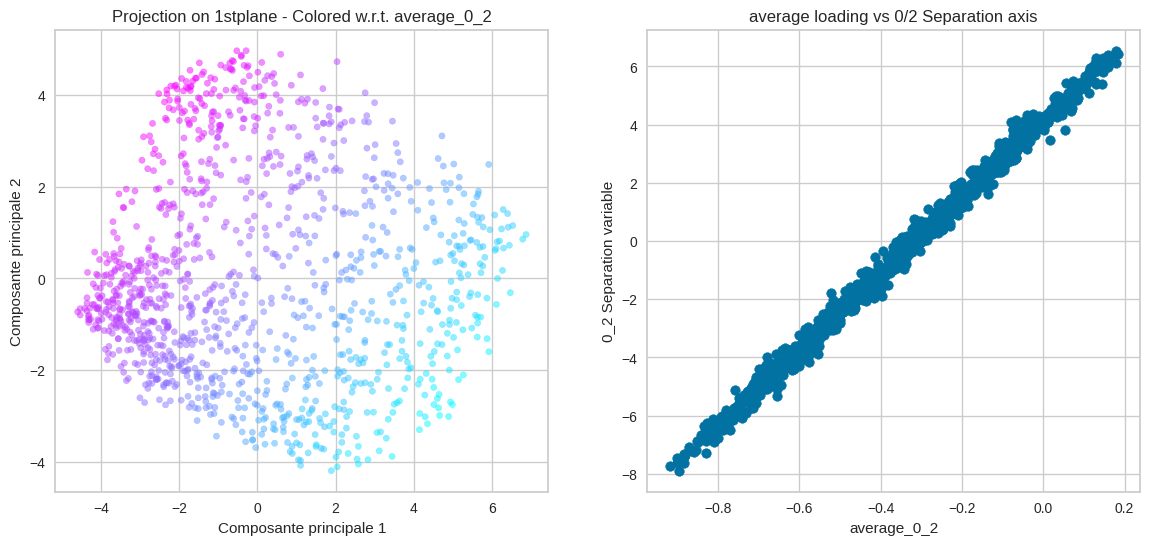

Correlation coefficient between labels_average-c1_average and y=x axis :  0.9615614892955119
Correlation coefficient between average_0_2 and y=x axis :  0.9974209658801013


In [72]:
fig, ax=plt.subplots(1,2,figsize=(14,6))

norm = plt.Normalize(vmin=min(average_0_2), vmax=max(average_0_2))
colors=[cmap(norm(average)) for average in average_0_2]

ax[0].scatter(data_pca2[:,0],data_pca2[:,1],alpha=0.5,s=20,c=colors)
ax[0].set_title('Projection on 1stplane - Colored w.r.t. average_0_2')
ax[0].set_xlabel('Composante principale 1')
ax[0].set_ylabel('Composante principale 2')

ax[1].scatter(average_0_2,data_pca2[:,1]-data_pca2[:,0])
ax[1].set_title('average loading vs 0/2 Separation axis')
ax[1].set_xlabel('average_0_2')
ax[1].set_ylabel('0_2 Separation variable')
plt.show()

correlation_coefficient = np.corrcoef(labels_average-c1_average, data_pca2[:,1]-data_pca2[:,0])[0, 1]
print("Correlation coefficient between labels_average-c1_average and y=x axis : ", correlation_coefficient)
correlation_coefficient = np.corrcoef(average_0_2, data_pca2[:,1]-data_pca2[:,0])[0, 1]
print("Correlation coefficient between average_0_2 and y=x axis : ", correlation_coefficient)

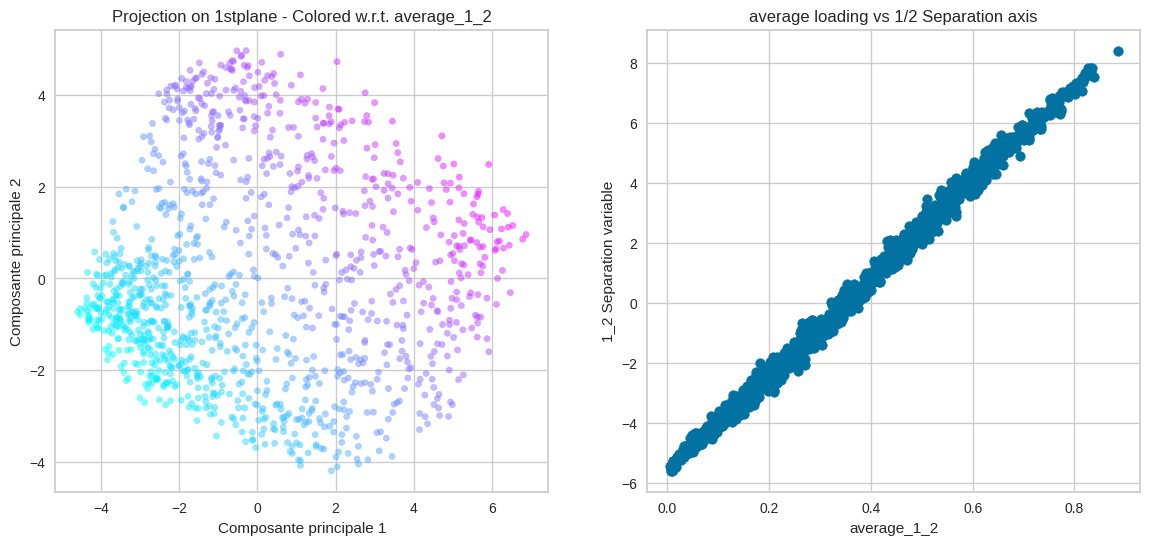

Correlation coefficient between labels_average-c1_average and y=x axis :  0.9687868654489754
Correlation coefficient between average_1_2 and y=-x axis :  0.9976676773262164


In [73]:
fig, ax=plt.subplots(1,2,figsize=(14,6))

norm = plt.Normalize(vmin=min(average_1_2), vmax=max(average_1_2))
colors=[cmap(norm(average)) for average in average_1_2]

ax[0].scatter(data_pca2[:,0],data_pca2[:,1],alpha=0.5,s=20,c=colors)
ax[0].set_title('Projection on 1stplane - Colored w.r.t. average_1_2')
ax[0].set_xlabel('Composante principale 1')
ax[0].set_ylabel('Composante principale 2')

ax[1].scatter(average_1_2,data_pca2[:,1]+data_pca2[:,0])
ax[1].set_title('average loading vs 1/2 Separation axis')
ax[1].set_xlabel('average_1_2')
ax[1].set_ylabel('1_2 Separation variable')
plt.show()

correlation_coefficient = np.corrcoef(labels_average+c1_average, data_pca2[:,1]+data_pca2[:,0])[0, 1]
print("Correlation coefficient between labels_average-c1_average and y=x axis : ", correlation_coefficient)
correlation_coefficient = np.corrcoef(average_1_2, data_pca2[:,1]+data_pca2[:,0])[0, 1]
print("Correlation coefficient between average_1_2 and y=-x axis : ", correlation_coefficient)

To best describe our diagonal separating axis, we have created new approximation axis : filter_0_2 and filter_0_1. If we compare the approximation produced by the new variable average_0_2 and average_1_2, and the ones produced by combining our previous approximations for the principal components (c1_average +- labels_average), our new variable appear to better separate the individuals along the diagonal axis and are more correlateted to these.

#### Now what exactly do these axis represent :

The first one represents the delta between the loading levels observed during the day and the loading levels observed during the night, with the latter being twice the magnitude of the former. It quantifies the variation in loading patterns between daytime and nighttime operations, **separating stations that are empty during the night and loaded during the working hours from the stations that follow the opposite movement (with a higher accent on night emptyness)**. we will now call this axis variable **"diag 1"**

The second one represents a positive weighted average of the loading levels during the day and the loading levels during week evenings. **Measure of the loading average during working hours, week_evenings and week-ends which both correspond to "go out" time (more weight is put for working hours)**. If we take a closer look, the combination used for this filter basically corresponds to an average on the "gathering hours" we first described when looking at the interactive loading map. we will now call this axis variable **"diag 2"**

They both provide insight into potential disparities in usage demand across different time periods.

# 4 Clusters

In [74]:
n_clusters=4
kmeans = KMeans(n_clusters, random_state =42)
kmeans.fit(loading_data)
Labels4= kmeans.labels_
coord['Labels4'] = Labels4

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



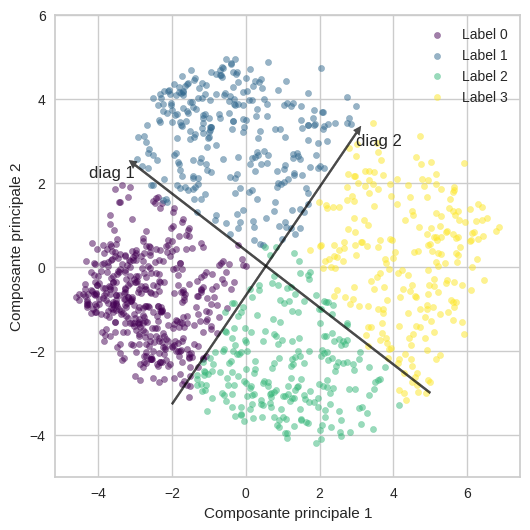

In [75]:
# Create a legend mapping label to color
norm = plt.Normalize(vmin=min(Labels4), vmax=max(Labels4))
colors=[cmapv(norm(label)) for label in set(Labels4)]
legend_dict = {label: color for label, color in zip(set(Labels4), colors)}

X3 = data_pca2[:, :2]
Y3 = [0 if (label==2 or label==3) else 1 for label in Labels4]

X4 = data_pca2[:, :2]
Y4 = [0 if (label==1 or label==3) else 1 for label in Labels4]

s3=svc.fit(X3,Y3)
x3 = np.linspace(-2, 3)
w3 = s3.coef_[0]
y3 = (-w3[0] / w3[1]) * x3 - (s3.intercept_[0]) / w3[1]

s4=svc.fit(X4,Y4)
x4 = np.linspace(-3, 5)
w4 = s4.coef_[0]
y4 = (-w4[0] / w4[1]) * x4 - (s4.intercept_[0]) / w4[1]

plt.figure(figsize=(6,6))
for label in set(Labels4):
    indices = Labels4 == label
    plt.scatter(data_pca2[indices, 0], data_pca2[indices, 1], alpha=0.5, s=20, color=legend_dict[label], label=f'Label {label}')

plt.ylim(-5, 6)
plt.arrow(x3[0], y3[0], x3[-1]-x3[0], y3[-1]-y3[0], color='black', width=0.05, head_width=0.2, head_length=0.2,alpha=0.7)
plt.text(x3[-1], y3[-1], 'diag 2', horizontalalignment='left', verticalalignment='top',fontsize=12)
plt.arrow(x4[-1], y4[-1], x4[0]-x4[-1], y4[0]-y4[-1], color='black', width=0.05, head_width=0.2, head_length=0.2,alpha=0.7)
plt.text(x4[0], y4[0], 'diag 1',horizontalalignment='right', verticalalignment='top',fontsize=12)
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.legend()
plt.show()

When choosing 4 clusters, the separating axes seem to be pretty much the same ones we considered right before. We can build interpretation from the precedent approximations.

# Interpretation of Station profiles and user patterns

The utility of introducing different filters to approximate distinct separating axis is to be able to describe what the different clusters corresponding to customer usages represent with words. The resulting variable is thus just a simple combination of the hours of the week.

In [76]:
fig = px.scatter_mapbox(coord, lat='latitude', lon='longitude',
                        color='Labels4',  # Use the 'Labels3' column for coloring
                        color_continuous_scale='viridis',  # Use the Viridis colormap
                        mapbox_style="carto-positron",
                        zoom=10, opacity=0.9,
                        title='Clustered stations')
fig.update_layout(
    height=800,
    width=1000,
)
fig.show()

### Customer usages corresponding to the clusters

* Let's start off with **stations labeled 1** : they have a high value for both diag 1 and diag 2 which means they tend to be empty during the night and loaded during working hours, week_evening and week_end days. Basically, **they are empty during the night and loaded during working and go-out time**

* Next off we've got **stations labeled 3** : they have a high value for diag 2 and low value for diag 1 which means they are not empty during the night and also loaded during the working hours week evening and week-ends. Basically, **they remain loaded all the time**.

* **Stations labeled 0** : High value for diag 1, low value for diag 2. **they are on average less loaded all the time**

* **Stations labeled 2** : Low value for both of the diag variables : **they are loaded during the night but not during working and go-out time**

In fact, we could have made the exact same interpretation using our first interpretations for the principal components, Since stations labeled 2 and 3 are separated by the first principal component and thus differ in loading average and stations labeled 0 and 1 differ because one group is loaded during working and go out time and the other during nightime.

* Stations labeled 1 mostly correspond to the very center of the city where people go to using the bikes during working and go-out time, and go back to their places out of the area for the night.
* Stations labeled 3 correspond to areas where people go the most to with their bike probably because a lot of bike users either work, spend some leisure time, or live in the area. looking at the map we recognise the animated districts of Paris.
  
* Stations labeled 2 are scattered further from the city center, there are less bike users in general.
  
* Stations labeled 0 are also scattered further from the city center but showcase higher loading rates during the night, they probably correspond to more residential neighborhoods. Bike users in these areas take the bikes from there to go to stations labeled 1 and 3, where they go-out or work and then come back to their neighborhood for the night.

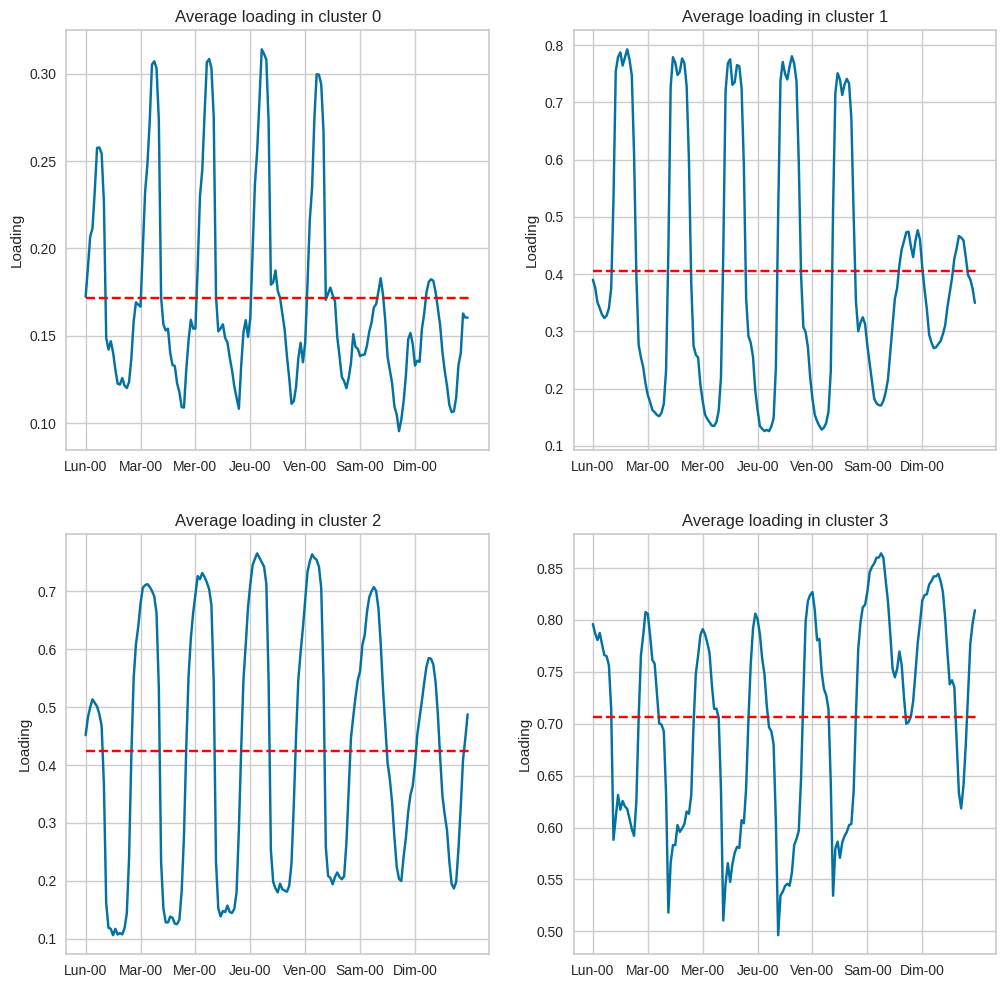

In [77]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

for k in range(4):
    row = k // 2
    col = k % 2


    ax[row, col].plot(load[Labels4 == k].mean())
    avg_value = load[Labels4 == k].mean().mean()
    ax[row, col].hlines(avg_value, xmin=0, xmax=168, color='red', linestyle='--', label='Average')
    ax[row, col].set_xticks(np.arange(0, 168, 24))
    ax[row, col].set_ylabel('Loading')
    ax[row, col].set_title(f'Average loading in cluster {k}')

plt.show()

The interpretations for each of the clusters made above are well illustrated on these graphs

Regrouper les variables temps avec le clustering sur transpose, seuiller les valeurs de loading, rajouter la variable hill, faire du clustering dans le plan de la MCA, comparer les classes. Faire une regression, tester si le coeff de pente est nul avec student.

# <FONT COLOR="Red">Clustering with MCA data   </font>

To perform MCA, we first need to transform our data into categorical data. To do so, we introduce different value ranges for the loading and map every loading data to its value range. Thus, we are left with discrete data that can be used as categorical data.

The advantage of performing clustering on the MCA data over the original data is that we can add categorical data directly into the analysis.
We will thusalso add the altitude categorical variable to the dataframe.

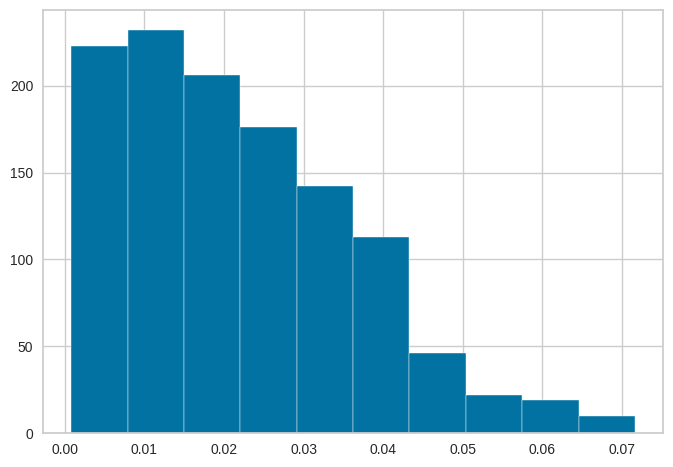

In [78]:
plt.hist(max_distances)
plt.show()

In [81]:
!pip install prince

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.8/415.8 kB 6.9 MB/s eta 0:00:00


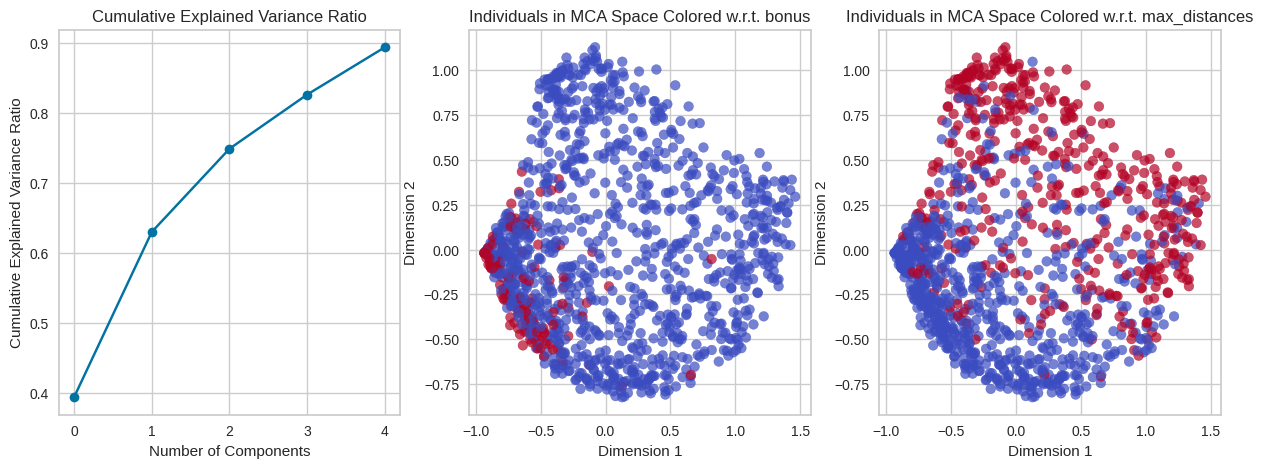

In [83]:
from prince import MCA

mca = MCA(n_components=5)
mca.fit(categorical_data)

row_coordinates = mca.row_coordinates(categorical_data)

fig, ax=plt.subplots(1,3,figsize=(15, 5))

ax[0].plot(np.cumsum(mca.eigenvalues_), marker='o', linestyle='-')
ax[0].set_title('Cumulative Explained Variance Ratio')
ax[0].set_xlabel('Number of Components')
ax[0].set_ylabel('Cumulative Explained Variance Ratio')

ax[1].scatter(row_coordinates.iloc[:, 0], row_coordinates.iloc[:, 1], c=categorical_data['bonus'], cmap='coolwarm',alpha=0.7)
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[1].set_title('Individuals in MCA Space Colored w.r.t. bonus')

ax[2].scatter(row_coordinates.iloc[:, 0], row_coordinates.iloc[:, 1], c=categorical_data['seine'], cmap='coolwarm',alpha=0.7)
ax[2].set_xlabel('Dimension 1')
ax[2].set_ylabel('Dimension 2')
ax[2].set_title('Individuals in MCA Space Colored w.r.t. max_distances')
plt.show()


In [84]:
num_subdivisions = 5

categorical_data = pd.DataFrame()

for col in load.columns:
    subdivisions = pd.cut(load[col], bins=num_subdivisions, labels=False)
    categorical_labels = [f'{i+1}' for i in subdivisions]
    temp_df = pd.DataFrame({col: categorical_labels})
    categorical_data = pd.concat([categorical_data, temp_df], axis=1)

categorical_data['bonus']=[1 if i==1 else 0 for i in coord['bonus']]
categorical_data['seine']=[1 if i<0.015 else 0 for i in max_distances]
categorical_data.head()

Lun-00 Lun-01 Lun-02 Lun-03 Lun-04 Lun-05 Lun-06 Lun-07 Lun-08 Lun-09  ...  \
0      1      1      1      1      1      1      1      1      1      1  ...   
1      3      3      3      3      3      3      3      3      2      1  ...   
2      2      1      1      1      1      1      1      1      1      1  ...   
3      5      5      5      5      5      5      5      5      5      5  ...   
4      5      5      4      4      4      4      4      4      4      5  ...   

  Dim-16 Dim-17 Dim-18 Dim-19 Dim-20 Dim-21 Dim-22 Dim-23 bonus seine  
0      1      1      2      1      1      1      1      1     0     0  
1      2      1      1      1      1      1      2      2     0     0  
2      2      1      1      2      2      2      2      3     0     1  
3      5      5      5      5      4      4      4      4     0     1  
4      3      5      5      5      4      4      4      3     0     1  

[5 rows x 170 columns]

We can observe that stations which have bonus=1 (altitude) seem to group pretty well together in the MCA Plane.
Also, quite similarly as in the PCA plane, the closest stations to the seine seem to have a higher value for the second component

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

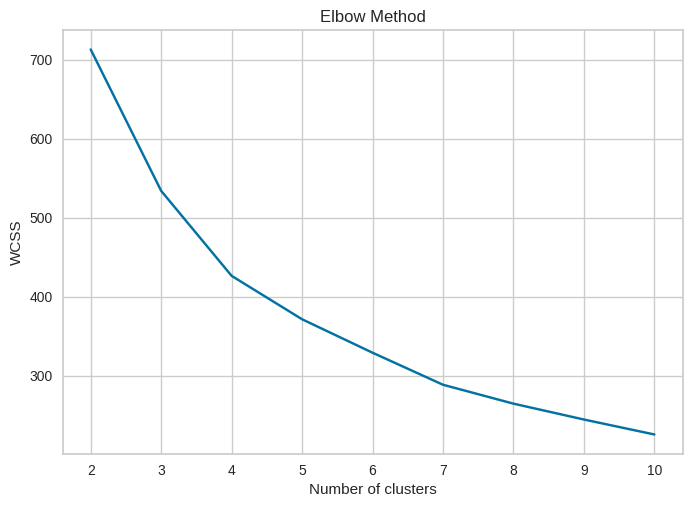

In [85]:
wcss = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(row_coordinates)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

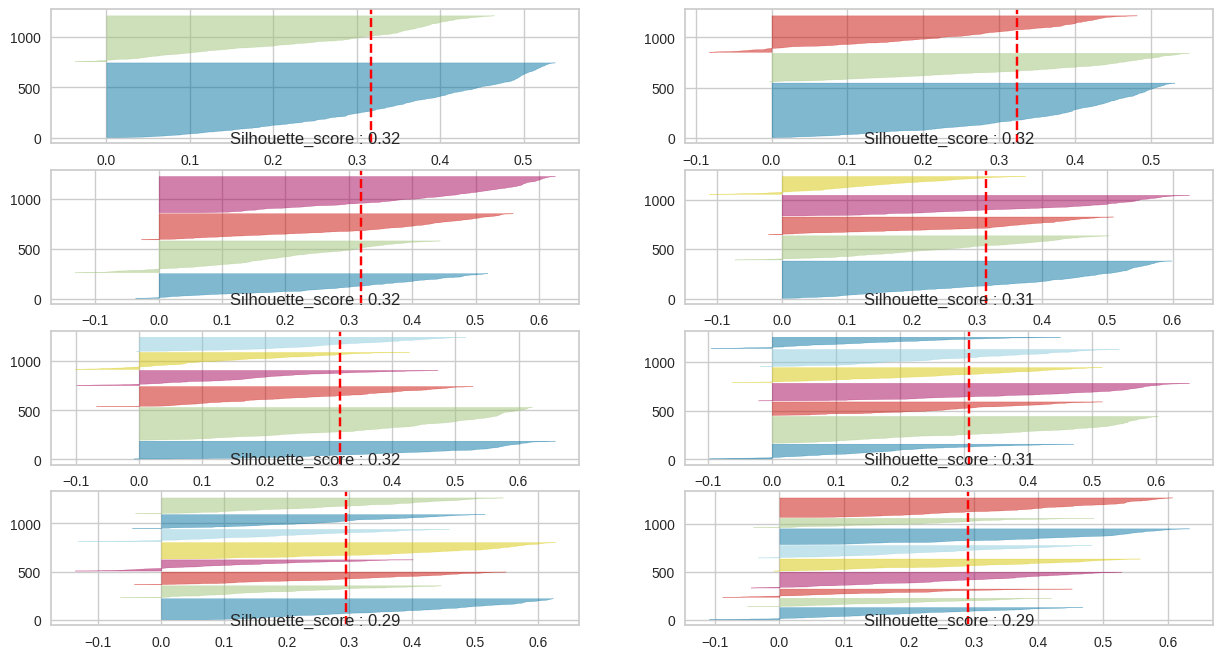

In [86]:
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(4,2, figsize=(15,8))

for k in range(2,10) :
    kmeans=KMeans(n_clusters=k,random_state=0)
    q,mod=divmod(k,2)
    visualizer=SilhouetteVisualizer(kmeans,colors='yellowbrick',ax=ax[q-1][mod])
    visualizer.fit(row_coordinates)
    silhouette_score=visualizer.silhouette_score_
    ax[q-1][mod].text(0.5,0,f'Silhouette_score : {silhouette_score:.2f}',transform=ax[q-1][mod].transAxes,ha='center')

plt.show()

Again here, the choice of 4 clusters really seems to be a decent choice looking at both the wcss graph and the silhouette scores.

In [87]:
n_clusters=4
kmeans = KMeans(n_clusters, random_state = 0)
kmeans.fit(row_coordinates)
MCALabels= kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



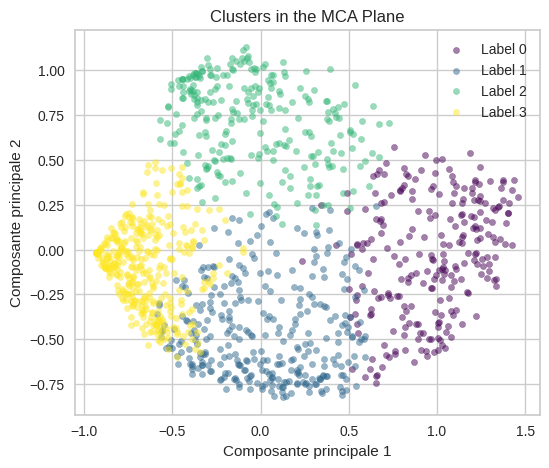

0.015748031496062992 percent of the altitude stations are labeled 2
0.45614035087719296 percent of the stations close to the seine are labeled 0 or 3


In [88]:
norm = plt.Normalize(vmin=min(MCALabels), vmax=max(MCALabels))
colors=[cmapv(norm(label)) for label in set(MCALabels)]
legend_dict = {label: color for label, color in zip(set(MCALabels), colors)}

plt.figure(figsize=(6,5))
for label in set(MCALabels):
    indices = MCALabels == label
    plt.scatter(row_coordinates.iloc[indices, 0], row_coordinates.iloc[indices, 1], alpha=0.5, s=20, color=legend_dict[label], label=f'Label {label}')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.title('Clusters in the MCA Plane')
plt.legend()
plt.show()

print(f'{sum(coord["bonus"]*np.array([1 if label==2 else 0 for label in MCALabels]))/sum(coord["bonus"])} percent of the altitude stations are labeled 2')
print(f'{sum(categorical_data["seine"]*np.array([1 if (label==0 or label ==3) else 0 for label in MCALabels]))/sum(categorical_data["seine"])} percent of the stations close to the seine are labeled 0 or 3')

We see that the green cluster (label 2) contains 86 percent of altitude stations. Stations labeled 2 might represent stations which are less loaded overall.

Also, 80 percent of the stations close to the seine are labeled 0 or 3.

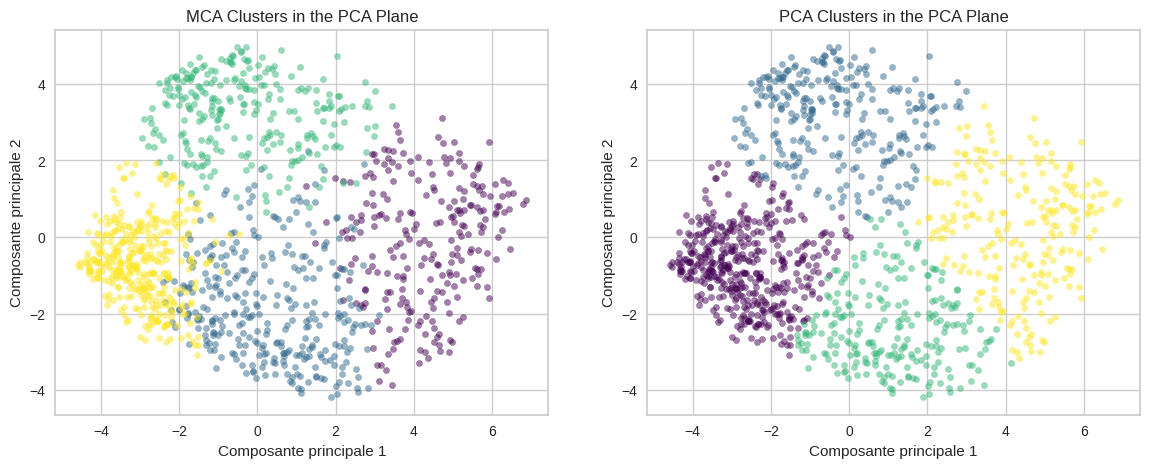

In [89]:
fig ,ax =plt.subplots(1,2,figsize=(14,5))
for label in set(MCALabels):
    indicesMCA = MCALabels == label
    indicesPCA = Labels4 ==label
    ax[0].scatter(data_pca2[indicesMCA, 0], data_pca2[indicesMCA, 1], alpha=0.5, s=20, color=legend_dict[label], label=f'Label {label}')
    ax[1].scatter(data_pca2[indicesPCA, 0], data_pca2[indicesPCA, 1], alpha=0.5, s=20, color=legend_dict[label], label=f'Label {label}')
ax[0].set_title('MCA Clusters in the PCA Plane')
ax[0].set_xlabel('Composante principale 1')
ax[0].set_ylabel('Composante principale 2')
ax[1].set_title('PCA Clusters in the PCA Plane')
ax[1].set_xlabel('Composante principale 1')
ax[1].set_ylabel('Composante principale 2')
plt.show()

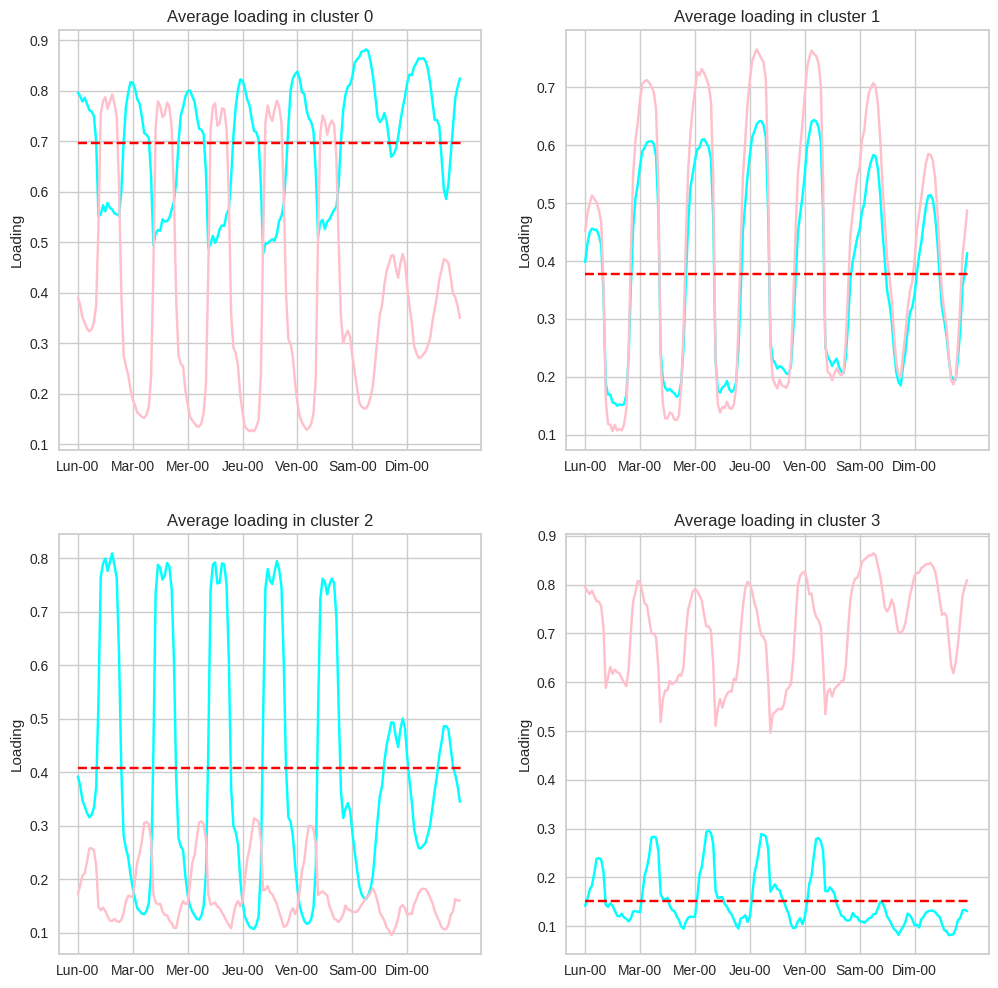

In [90]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
correspondance=[1,2,0,3]
for k in range(4):
    row = k // 2
    col = k % 2


    ax[row, col].plot(load[MCALabels == k].mean(),color='cyan')
    ax[row,col].plot(load[Labels4 == correspondance[k]].mean(),color='pink')
    avg_value = load[MCALabels == k].mean().mean()
    ax[row, col].hlines(avg_value, xmin=0, xmax=168, color='red', linestyle='--', label='Average')
    ax[row, col].set_xticks(np.arange(0, 168, 24))
    ax[row, col].set_ylabel('Loading')
    ax[row, col].set_title(f'Average loading in cluster {k}')

plt.show()

From the two precedent figures, we conclude that adding quantitative variables such as altitude 'bonus' and closeness to the seine don't significantly change the clusters prediction, interpretations made before remain viable.